In [1]:
# reads last disk-saved version of Excel files via temp copy (no more permission denied errors)
import tempfile
import shutil
import os
import pandas as pd

def read_excel(filename):
    """Reads an Excel file that may be locked and returns a DataFrame."""
    temp_fd, temp_path = tempfile.mkstemp(suffix=".xlsx")
    os.close(temp_fd)  # Close the handle immediately

    try: # Attempt to copy the file even if it's locked
        shutil.copy2(filename, temp_path)  
        df = pd.read_excel(temp_path)  # Read the temporary copy 
        return df
    
    except Exception as e:
        print(f"Error reading file: {e}")
        return None
    
    finally: # Remove the temporary file 
        if os.path.exists(temp_path):
            os.remove(temp_path)


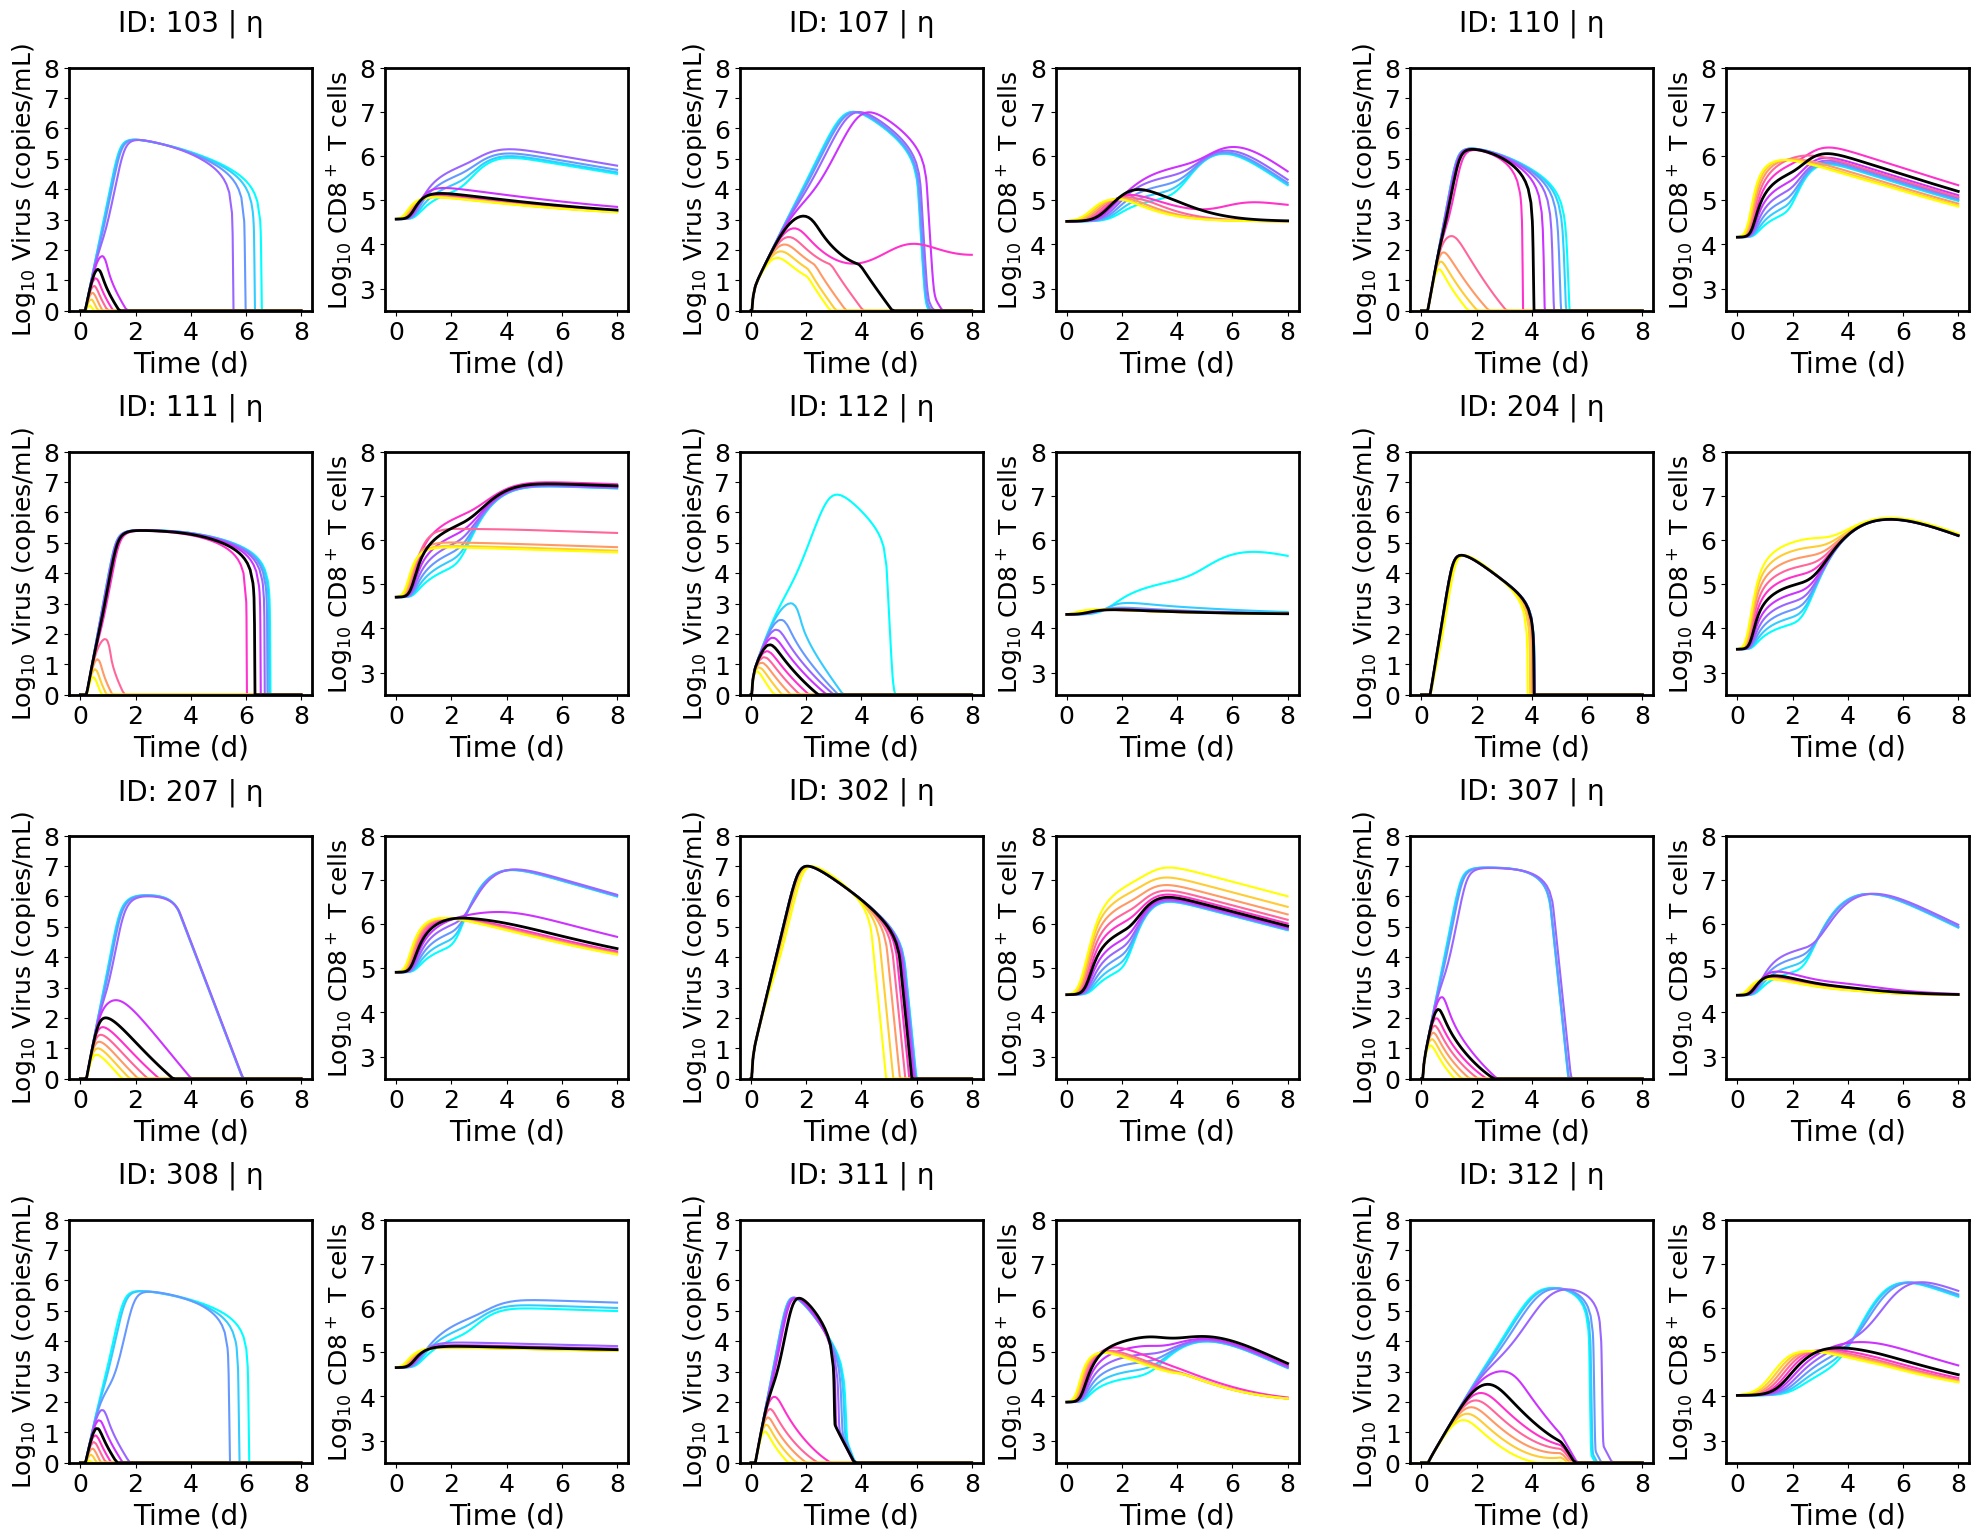

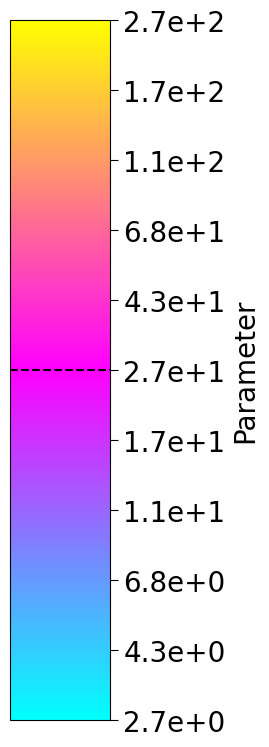

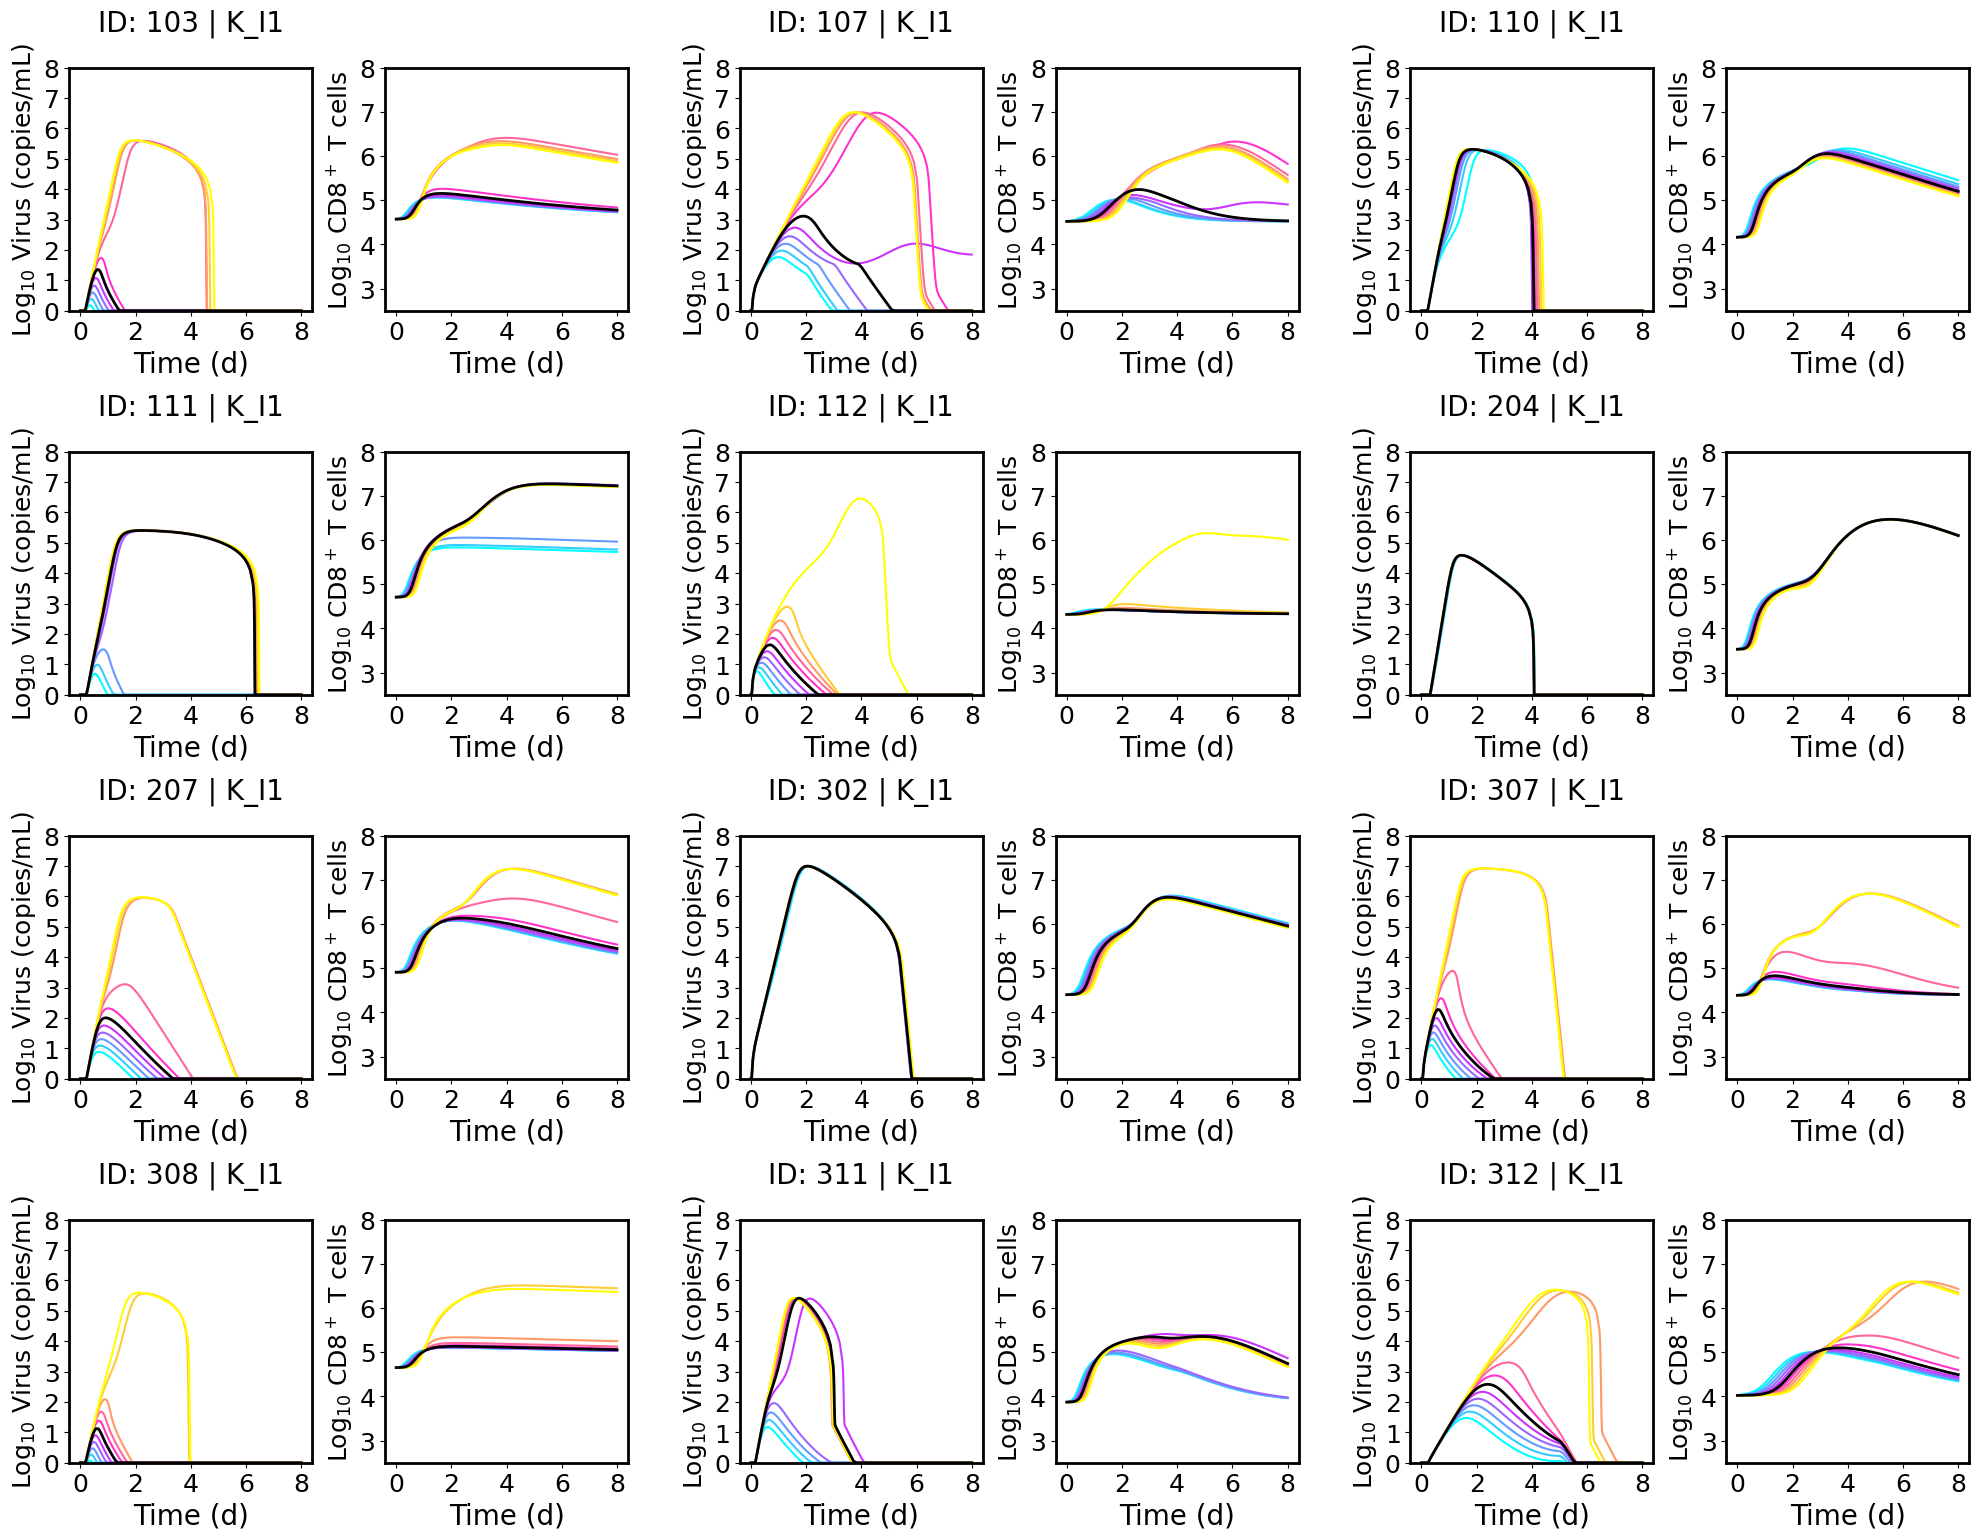

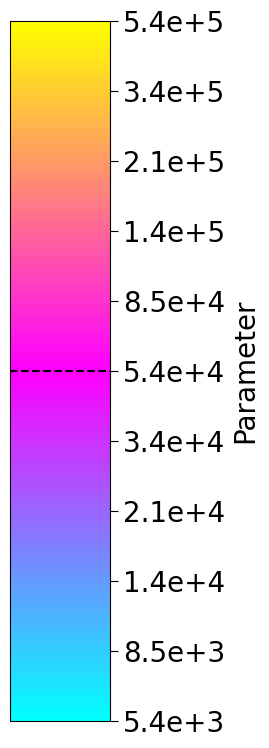

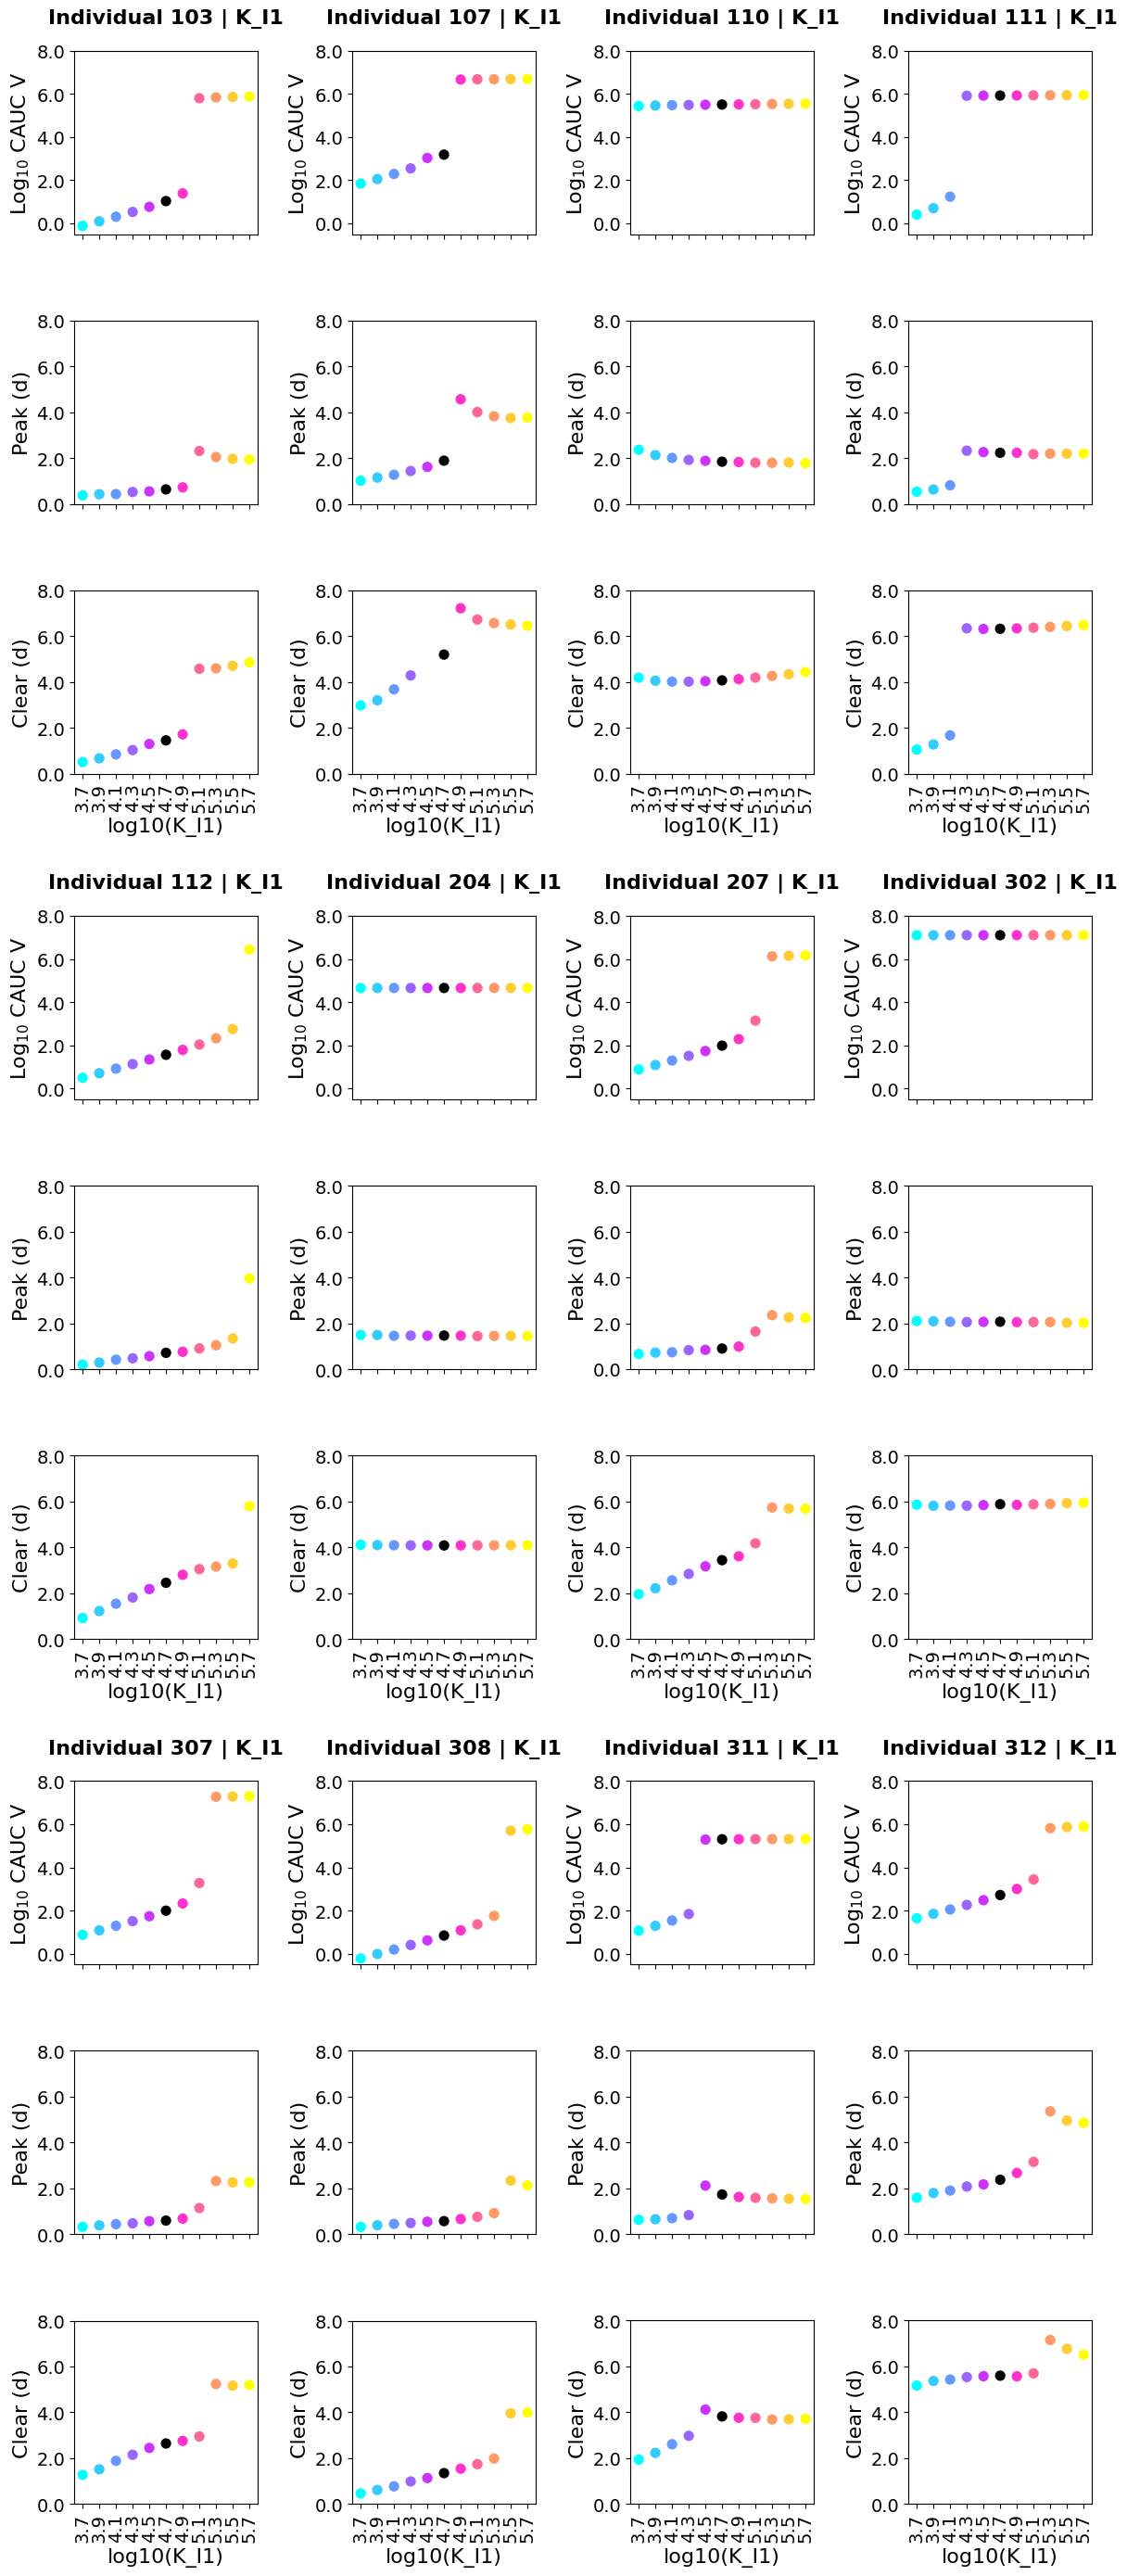

In [36]:
from julia.api import Julia
from julia import Main
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import re
import math

os.environ["JULIA_NUM_THREADS"] = "1"
julia = Julia(sysimage="sysimage_env/sysimage.so")
Main.include("models/Reinfection_model.jl")

def custom_sci_formatter(x, pos):
    # Format number in scientific notation with one digit in the mantissa.
    s = f"{x:.1e}"
    s = s.replace("e+0", "e+").replace("e-0", "e-")
    return s

def format_fit_params(fit_parameters):
    if isinstance(fit_parameters, list) and len(fit_parameters) > 1:
        fit_params_str = " ".join(fit_parameters)
    else:
        fit_params_str = fit_parameters[0] if isinstance(fit_parameters, list) else fit_parameters
    replacements = {
        r"\bd_E\b": "dE",
        r"\bdelta\b": "δ",
        r"\bdelta_E\b": "δE",
        r"\bK_delta_E\b": "K(δE)",
        r"\btau\b": "τ",
        r"\bxi\b": "ξ",
        r"\bbeta\b": "β",
        r"\bdelta_E/K_delta_E\b": "Log10 [δE/KδE]",
        r"\bdelta/delta_E\b": "δ/δE",
        r"\beta\b": "η",
        r"\bzeta\b": "ζ",
        r"\btau_memory\b": "τm",
    }
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)
    return fit_params_str

def run_simulation(t_span, y0, base_params, sweep_param, percent=None, log=None):
    base_value = base_params[sweep_param]
    n_points = 101  # adjust as needed
    if percent is not None and log is None:
        sweep_range = (base_value * (1 - percent/100), base_value * (1 + percent/100))
        sweep_values = np.linspace(sweep_range[0], sweep_range[1], n_points)
    elif log is not None and percent is None:
        sweep_range = (base_value * (10 ** -log), base_value * (10 ** log))
        sweep_values = 10 ** np.linspace(np.log10(sweep_range[0]), np.log10(sweep_range[1]), n_points)
    else:
        raise ValueError("Either percent or log must be provided exclusively.")
    solutions = []
    for value in sweep_values:
        params = {k: v for k, v in base_params.items() if k not in ["T0", "ME"]}
        params[sweep_param] = value
        if sweep_param == "T0":
            y0[0] = value
        else:
            y0[0] = float(base_params["T0"])
        if sweep_param == "ME":
            y0[5] = value
        else:
            y0[5] = base_params["ME"]
        params_julia = [
            float(np.float64(params["beta"])),
            float(np.float64(params["k"])),
            float(np.float64(params["p"])),
            float(np.float64(params["c"])),
            float(np.float64(params["delta"])),
            float(np.float64(params["xi"])),
            float(np.float64(params["a"])),
            float(np.float64(params["d_E"])),
            float(np.float64(params["delta_E"])),
            float(np.float64(params["K_delta_E"])),
            float(np.float64(params["zeta"])),
            float(np.float64(params["eta"])),
            float(np.float64(params["K_I1"])),
            float(np.float64(params["tau_memory"])),
            float(np.float64(params["damp"]))
        ]
        t_values, y_values = Main.tmap_ReinfectionModel(t_span, y0, params_julia)
        sol = {"t": np.array(t_values, dtype=np.float64),
               "y": np.array(y_values, dtype=np.float64)}
        solutions.append(sol)
    # Compute metrics.
    cauc_values, peak_days, clear_days = [], [], []
    for sol in solutions:
        t = sol["t"]
        virus = sol["y"][3, :]
        auc = np.trapezoid(virus, t)
        cauc_values.append(auc)
        peak_idx = np.argmax(virus)
        peak_days.append(t[peak_idx])
        clear_time = np.nan
        for i in range(peak_idx+1, len(t)):
            if virus[i] < 1:
                clear_time = t[i]
                break
        clear_days.append(clear_time)
    # Run baseline simulation.
    y0[0] = 4E7  
    y0[5] = base_params["ME"]
    baseline_params = {k: v for k, v in base_params.items() if k != "T0"}
    baseline_t, baseline_y = Main.tmap_ReinfectionModel(t_span, y0, list(baseline_params.values()))
    baseline = {"t": np.array(baseline_t, dtype=np.float64),
                "y": np.array(baseline_y, dtype=np.float64)}
    if log is not None:
        subset_tick_values = 10 ** np.linspace(np.log10(sweep_range[0]), np.log10(sweep_range[1]), 11)
    else:
        subset_tick_values = np.linspace(sweep_range[0], sweep_range[1], 11)
    dynamics_indices = []
    for tick in subset_tick_values:
        if np.isclose(tick, base_value):
            continue
        idx = np.argmin(np.abs(sweep_values - tick))
        dynamics_indices.append(idx)
    dynamics_indices = np.array(dynamics_indices)
    return {
        "sweep_values": sweep_values,
        "solutions": solutions,
        "baseline": baseline,
        "cauc_values": np.array(cauc_values),
        "peak_days": np.array(peak_days),
        "clear_days": np.array(clear_days),
        "subset_tick_values": subset_tick_values,
        "dynamics_indices": dynamics_indices,
        "base_value": base_value,
        "sweep_range": sweep_range
    }

def plot_individual_dynamics(fig, cell_gs, sim_data, t_span, Zero_conditions, sweep_param, indiv_id, log):
    """
    In a given cell (a SubplotSpec), plot the dynamics (virus and effector) for one individual.
    """
    # Create a grid with 1 row, 2 columns (two axes for dynamics)
    gs_dyn = mpl.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=cell_gs, wspace=0.3)
    ax_virus = fig.add_subplot(gs_dyn[0])
    ax_effector = fig.add_subplot(gs_dyn[1])

    # Set all spines to black and 2 points thick
    for spine in ax_virus.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    for spine in ax_effector.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)

    base_value = sim_data["base_value"]
    sweep_values = sim_data["sweep_values"]
    solutions = sim_data["solutions"]
    subset_tick_values = sim_data["subset_tick_values"]
    dynamics_indices = sim_data["dynamics_indices"]

    cmap_decrease = plt.get_cmap("cool")
    cmap_increase = plt.get_cmap("spring")
    if log is not None:
        norm_decrease = mpl.colors.LogNorm(vmin=sweep_values[0], vmax=base_value)
        norm_increase = mpl.colors.LogNorm(vmin=base_value, vmax=sweep_values[-1])
    else:
        norm_decrease = mpl.colors.Normalize(vmin=sweep_values[0], vmax=base_value)
        norm_increase = mpl.colors.Normalize(vmin=base_value, vmax=sweep_values[-1])

    # Plot selected dynamics traces.
    for idx in dynamics_indices:
        val = sweep_values[idx]
        color = cmap_decrease(norm_decrease(val)) if val < base_value else cmap_increase(norm_increase(val))
        sol = solutions[idx]
        ax_virus.plot(sol["t"], np.log10(np.maximum(sol["y"][3, :], 1)), color=color, linewidth=1.5)
        ax_effector.plot(sol["t"], np.log10(np.maximum(sol["y"][4, :] + sol["y"][5, 0], 1)), color=color, linewidth=1.5)

    # Plot the baseline in black.
    baseline = sim_data["baseline"]
    ax_virus.plot(baseline["t"], np.log10(np.maximum(baseline["y"][3, :], 1)), color='black', linewidth=2)
    ax_effector.plot(baseline["t"], np.log10(np.maximum(baseline["y"][4, :] + Zero_conditions["ME"], 1)),
                     color='black', linewidth=2)

    # Set integer y-ticks for both axes.
    ax_virus.set_yticks(np.arange(0, 9, 1))  # Virus axis (0 to 8)
    ax_effector.set_yticks(np.arange(2, 9, 1))  # Effector axis (2.5 to 8)

    # Set fixed x-ticks at days 0, 2, 4, 6, and 8.
    ax_virus.set_xticks([0, 2, 4, 6, 8])
    ax_effector.set_xticks([0, 2, 4, 6, 8])

    # Label axes.
    ax_virus.set_ylabel(f'Log$_{{10}}$ Virus (copies/mL)', fontsize=18)
    ax_effector.set_ylabel(f'Log$_{{10}}$ CD8$^+$ T cells', fontsize=18)
    ax_virus.set_xlabel("Time (d)", fontsize=20)
    ax_effector.set_xlabel("Time (d)", fontsize=20)

    # Adjust tick label sizes.
    ax_virus.tick_params(labelsize=18)
    ax_effector.tick_params(labelsize=18)

    # Set y-axis limits.
    ax_virus.set_ylim(0, 8)
    ax_effector.set_ylim(2.5, 8)

    # Ensure aspect ratio consistency.
    ax_virus.set_box_aspect(1)
    ax_effector.set_box_aspect(1)

    # Add title above virus subplot.
    ax_virus.text(0.5, 1.15, f"ID: {indiv_id} | {format_fit_params(sweep_param)}",
                  transform=ax_virus.transAxes, fontsize=20, ha='center')

def create_global_colorbar(fig, rep_sim, log):
    """
    Create a standalone vertical colorbar using representative simulation data.
    Ensures that only the subset tick positions are displayed (no extra ticks).
    """
    rep_sweep = rep_sim["sweep_values"]
    rep_base = rep_sim["base_value"]
    
    # Define colormap and normalization
    cmap_decrease = plt.get_cmap("cool")
    cmap_increase = plt.get_cmap("spring")
    if log is not None:
        global_norm = mpl.colors.LogNorm(vmin=rep_sweep.min(), vmax=rep_sweep.max())
    else:
        global_norm = mpl.colors.Normalize(vmin=rep_sweep.min(), vmax=rep_sweep.max())
    
    # Merge color maps
    colors_merged = np.vstack((cmap_decrease(np.linspace(0, 1, 128)),
                               cmap_increase(np.linspace(0, 1, 128))))
    merged_cmap = mpl.colors.ListedColormap(colors_merged)
    
    # Create colorbar axis
    cbar_ax = fig.add_axes([0.25, 0.15, 0.1, 0.7])  # [left, bottom, width, height]
    cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=merged_cmap, norm=global_norm, orientation='vertical')

    # **Force ONLY subset tick positions**
    subset_ticks = rep_sim["subset_tick_values"]
    cbar.set_ticks(subset_ticks)  # Set tick positions
    cbar.set_ticklabels([custom_sci_formatter(val, None) for val in subset_ticks])  # Set labels
    
    # **Override both major and minor tick locators to fully eliminate auto-generated ticks**
    cbar.ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(subset_ticks))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.FixedLocator([]))  # Remove all minor ticks
    cbar.ax.minorticks_off()  # Ensure no minor ticks appear

    # Add horizontal line at the base parameter value
    cbar.ax.axhline(rep_base, color='black', linewidth=1.5, linestyle='--')

    # Adjust tick mark appearance
    cbar.ax.tick_params(labelsize=20, which='both', length=6)
    
    # Set y-axis label
    cbar.ax.set_ylabel("Parameter", fontsize=20)


params = pd.read_excel("Rechallenge.xlsx")
ids = params[params['id'] != 'Population']['id'].unique() 


patient_color_names = ['gray', 'purple', 'magenta', 'red', 'goldenrod', 'darkorange',
                        'saddlebrown', 'mediumblue', 'dodgerblue', 'turquoise', 'darkgreen', 'lawngreen']
patient_colors = {}
for pid, cname in zip(ids, patient_color_names):
    rgba = mcolors.to_rgba(cname)
    patient_colors[pid] = {'matplotlib': rgba, 'plotly': mpl.colors.to_hex(rgba, keep_alpha=False)}

df_Rahil = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx")
df_Rahil = df_Rahil[['VOLUNTEER', 'DAY', 'V', 'TSS', 'CD8TE', 'CD8TM', 'COHORT']]
df_Rahil = df_Rahil[(df_Rahil['DAY'] < 9) & (df_Rahil['DAY'] > -0.01)]
df_Rahil = df_Rahil[df_Rahil['VOLUNTEER'].isin(ids)]

t_span = (0.0, 8)
y0_master = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0]*13

percent = 50
log = 1
swept_params = ["eta", "K_I1"]

# For each swept parameter, pre-compute simulation data and global metric y-limits.
for sweep_param in swept_params:
    all_auc, all_peak, all_clear = [], [], []
    sim_data_dict = {}
    for indiv_id in ids:
        row = params[params['id'] == indiv_id].iloc[0]
        base_params = {
            "T0": row['T0'],
            "beta": row['beta'],
            "k": row['k'],
            "p": row['p'],
            "c": row['c'],
            "delta": row['delta'],
            "xi": row['xi'],
            "a": row['a'],
            "d_E": row['d_E'],
            "delta_E": row['delta_E'],
            "K_delta_E": row['K_delta_E'],
            "zeta": row['zeta'],
            "eta": row['eta'],
            "K_I1": row['K_I1'],
            "tau_memory": row['tau_memory'],
            "damp": row['damp'],
            "ME": row['ME']
        }
        Zero_conditions = {"ME": row['ME'], "M0": row['M0']}
        y0_local = y0_master.copy()
        sim_data = run_simulation(t_span, y0_local, base_params, sweep_param, percent=None, log=log)
        sim_data_dict[indiv_id] = (sim_data, Zero_conditions)
        all_auc.append(sim_data["cauc_values"])
        all_peak.append(sim_data["peak_days"])
        all_clear.append(sim_data["clear_days"])
    global_auc_min = np.log10(np.min([np.min(arr) for arr in all_auc]))
    global_auc_max = np.log10(np.max([np.max(arr) for arr in all_auc]))
    global_peak_min = np.min([np.min(arr) for arr in all_peak])
    global_peak_max = np.max([np.max(arr) for arr in all_peak])
    global_clear_min = np.nanmin([np.nanmin(arr) for arr in all_clear])
    global_clear_max = np.nanmax([np.nanmax(arr) for arr in all_clear])
    
    n_indiv = len(ids)
    n_cols = 3
    n_rows = math.ceil(n_indiv / n_cols)
    
    # ----- Dynamics Figure -----
    fig_dyn = plt.figure(figsize=(20, 16))
    outer_gs_dyn = gridspec.GridSpec(n_rows, n_cols, figure=fig_dyn)
    for i, indiv_id in enumerate(ids):
        cell_gs = outer_gs_dyn[i]
        sim_data, Zero_conditions = sim_data_dict[indiv_id]
        plot_individual_dynamics(fig_dyn, cell_gs, sim_data, t_span, Zero_conditions, sweep_param, indiv_id, log)
    plt.subplots_adjust(left=0.03, right=0.98, top=0.95, bottom=0.03)
    plt.show()
    
    # ----- Global Colorbar Figure -----
    fig_cbar = plt.figure(figsize=(10, 10))
    # Use representative simulation data from the first individual.
    rep_sim = sim_data_dict[ids[0]][0]
    create_global_colorbar(fig_cbar, rep_sim, log)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
    plt.show()


def plot_individual_metrics(fig, cell_gs, sim_data, sweep_param, indiv_id, log, ylims_auc, ylims_peak, ylims_clear):
    """
    In a given cell (a SubplotSpec), plot the metrics for one individual:
    Three stacked square subplots (CAUC, Peak Day, Clear Day) sharing the x–axis.
    
    - The CAUC axis y–label is "XeX".
    - The Peak and Clear day y–axis ticks are formatted as regular numbers with 1 decimal.
    - The x–axis is labeled "log10({parameter})" (only on the bottom subplot).
    - All fonts are at least size 16.
    """
    # Create 3 subplots sharing the x–axis with minimal vertical spacing.
    gs_met = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=cell_gs, hspace=0)
    ax_auc   = fig.add_subplot(gs_met[0])
    ax_peak  = fig.add_subplot(gs_met[1], sharex=ax_auc)
    ax_clear = fig.add_subplot(gs_met[2], sharex=ax_auc)
    
    # Hide x tick labels for the top two subplots.
    plt.setp(ax_auc.get_xticklabels(), visible=False)
    plt.setp(ax_peak.get_xticklabels(), visible=False)
    
    # Compute x–axis values.
    if log is not None:
        x_metric = np.log10(sim_data["sweep_values"])
        subset_x = np.log10(sim_data["subset_tick_values"])
    else:
        x_metric = sim_data["sweep_values"]
        subset_x = sim_data["subset_tick_values"]
    
    # Plot smooth metric lines.
    #ax_auc.plot(x_metric, np.log10(sim_data["cauc_values"]), color='blue', linewidth=2)
    #ax_peak.plot(x_metric, sim_data["peak_days"], color='green', linewidth=2)
    #ax_clear.plot(x_metric, sim_data["clear_days"], color='red', linewidth=2)
    
    # Generate marker colors.
    marker_colors = []
    base_value = sim_data["base_value"]
    cmap_decrease = plt.get_cmap("cool")
    cmap_increase = plt.get_cmap("spring")
    
    if log is not None:
        norm_decrease = mpl.colors.LogNorm(vmin=sim_data["sweep_values"][0], vmax=base_value)
        norm_increase = mpl.colors.LogNorm(vmin=base_value, vmax=sim_data["sweep_values"][-1])
    else:
        norm_decrease = mpl.colors.Normalize(vmin=sim_data["sweep_values"][0], vmax=base_value)
        norm_increase = mpl.colors.Normalize(vmin=base_value, vmax=sim_data["sweep_values"][-1])
    
    for tick in sim_data["subset_tick_values"]:
        if np.isclose(tick, base_value):
            marker_colors.append('black')
        else:
            marker_colors.append(cmap_decrease(norm_decrease(tick)) if tick < base_value else cmap_increase(norm_increase(tick)))
    # Add markers at the subset tick positions.
    for ax, metric, label in zip([ax_auc, ax_peak, ax_clear],
                                 [np.log10(sim_data["cauc_values"]), sim_data["peak_days"], sim_data["clear_days"]],
                                 ["CAUC", "Peak Day", "Clear Day"]):
        marker_vals = [metric[np.argmin(np.abs(sim_data["sweep_values"] - tick))] for tick in sim_data["subset_tick_values"]]
        ax.scatter(subset_x, marker_vals, color=marker_colors, zorder=5, s=50)
    
    # Set x-axis label only on the bottom subplot.
    ax_clear.set_xlabel(f"log10({format_fit_params(sweep_param)})", fontsize=16)
    
    # Set x–ticks to appear only on the bottom subplot.
    ax_clear.set_xticks(subset_x)
    ax_clear.set_xticklabels([f"{np.log10(val):.1f}" for val in sim_data["subset_tick_values"]], fontsize=14, rotation=90)
    
    # Apply global y–limits.
    ax_auc.set_ylim(-0.5, 8)
    ax_peak.set_ylim(0, 8)
    ax_clear.set_ylim(0, 8)
    
    # Force each subplot to be square.
    for ax in [ax_auc, ax_peak, ax_clear]:
        ax.set_box_aspect(1)  # 1:1 aspect ratio
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
    # Format CAUC y–ticks as scientific notation without excessive decimals.
    ax_auc.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    #ax_auc.set_yticks(np.arange(ax_auc.get_ylim()[0], ax_auc.get_ylim()[1] + 0.5, 3))

    # Format Peak and Clear day y-ticks as standard numbers with one decimal.
    ax_peak.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax_clear.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    
    # Label the y–axes.
    ax_auc.set_ylabel(f'Log$_{{10}}$ CAUC V', fontsize=16)
    ax_peak.set_ylabel("Peak (d)", fontsize=16)
    ax_clear.set_ylabel("Clear (d)", fontsize=16)
    
    # Add title text above the top subplot.
    ax_auc.text(0.5, 1.15, f"Individual {indiv_id} | {format_fit_params(sweep_param)}", 
                transform=ax_auc.transAxes, fontsize=16, ha='center', fontweight='bold')


# Adjust number of individuals, rows, and columns
n_indiv = len(ids)
n_cols = 4  # Adjusting to fit better
n_rows = math.ceil(n_indiv / n_cols)

# Adjust figure size and use constrained layout
fig_met = plt.figure(figsize=(12, 28), constrained_layout=True)
outer_gs_met = gridspec.GridSpec(n_rows, n_cols, figure=fig_met, wspace=0.05, hspace=0.05)  # Reduced spacing

# Loop through individuals and plot their metrics
for i, indiv_id in enumerate(ids):
    cell_gs = outer_gs_met[i]
    sim_data, _ = sim_data_dict[indiv_id]
    plot_individual_metrics(fig_met, cell_gs, sim_data, sweep_param, indiv_id, log,
                            (global_auc_min, global_auc_max),
                            (global_peak_min, global_peak_max),
                            (global_clear_min, global_clear_max))

# Show plot
plt.show()


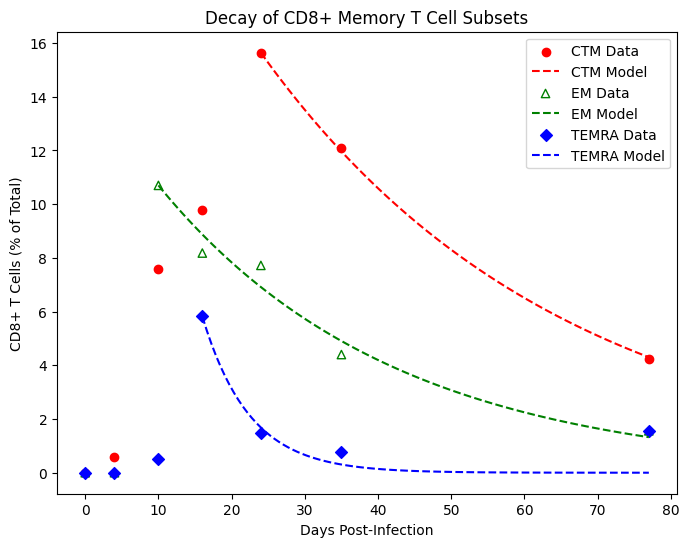

,Initial Peak Value,Decay rate (k),Half-life (days),Estimated Lifespan (days)
CTM,15.64,0.024352,28.463339,85.390018
EM,10.70,0.031192,22.221751,66.665254
TEMRA,5.82,0.155054,4.470349,13.411047


In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Given data
data = {
    "Day": [0, 4, 10, 16, 24, 35, 77],
    "CTM": [0.00, 0.57, 7.58, 9.77, 15.64, 12.09, 4.23],
    "EM": [0.00, 0.00, 10.70, 8.18, 7.72, 4.40, 1.56],
    "TEMRA": [0.00, 0.00, 0.51, 5.82, 1.48, 0.77, 1.56]
}

df = pd.DataFrame(data)

# Define exponential decay function
def constrained_exp_decay(t, k, initial_value):
    return initial_value * np.exp(-k * t)

# Dictionary to store refined decay parameters
decay_params_refined = {}

# Define unique colors and markers for each subset
colors = {"CTM": "red", "EM": "green", "TEMRA": "blue"}
markers = {"CTM": "o", "EM": "^", "TEMRA": "D"}

# Create plot
plt.figure(figsize=(8, 6))

for subset in ["CTM", "EM", "TEMRA"]:
    # Extract peak and restrict to post-peak period
    peak_index = np.argmax(df[subset])
    t_fit = np.array(df["Day"][peak_index:])  # Days after peak
    y_fit = np.array(df[subset][peak_index:])  # Cell % after peak
    initial_value = y_fit[0]  # Peak value as the fixed starting point

    # Shift time to start at peak (t=0 at peak)
    t_shifted = t_fit - t_fit[0]

    # Fit the decay curve
    popt, _ = curve_fit(lambda t, k: constrained_exp_decay(t, k, initial_value),
                        t_shifted, y_fit, p0=[0.01], maxfev=5000)
    k_fit = popt[0]
    half_life = np.log(2) / k_fit
    estimated_lifespan = 3 * half_life  # Approximate meaningful presence duration

    # Store results
    decay_params_refined[subset] = {
        "Initial Peak Value": initial_value,
        "Decay rate (k)": k_fit,
        "Half-life (days)": half_life,
        "Estimated Lifespan (days)": estimated_lifespan
    }

    # Scatter plot for observed data
    if subset == "EM":
        plt.scatter(df["Day"], df[subset], label=f"{subset} Data", marker=markers[subset], edgecolor=colors[subset], facecolor='none')
    else:
        plt.scatter(df["Day"], df[subset], label=f"{subset} Data", marker=markers[subset], color=colors[subset])

    # Generate model fit within its fitted period
    t_model = np.linspace(t_fit[0], t_fit[-1], 100)
    plt.plot(t_model, constrained_exp_decay(t_model - t_fit[0], k_fit, initial_value), label=f"{subset} Model", color=colors[subset], linestyle="--")

# Formatting the plot
plt.xlabel("Days Post-Infection")
plt.ylabel("CD8+ T Cells (% of Total)")
plt.title("Decay of CD8+ Memory T Cell Subsets")
plt.legend()
plt.show()

# Convert results to DataFrame and display
decay_df_refined = pd.DataFrame(decay_params_refined).T
decay_df_refined


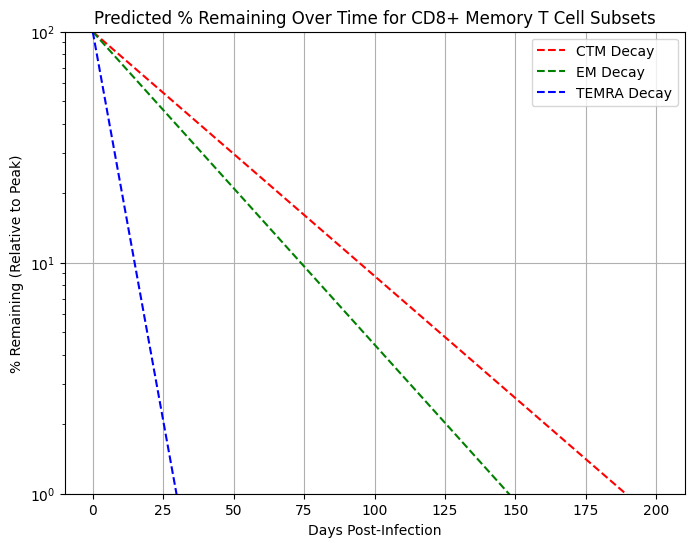

Drop Below 10%:
  Subset  Days Below 10%
0    CTM       94.949495
1     EM       74.747475
2  TEMRA       16.161616

Drop Below 1%:
  Subset  Days Below 1%
0    CTM     189.898990
1     EM     149.494949
2  TEMRA      30.303030


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define time range for prediction
t_pred = np.linspace(0, 200, 100)  # 200 days

# Create plot
plt.figure(figsize=(8, 6))

# Initialize lists to store results
drop_below_10 = []
drop_below_1 = []

for subset, params in decay_params_refined.items():
    k_fit = params["Decay rate (k)"]

    # Predict % remaining (relative to peak)
    y_pred = 100 * np.exp(-k_fit * t_pred)

    # Check when the predicted values drop below 10% and 1%
    days_below_10 = t_pred[y_pred < 10]
    days_below_1 = t_pred[y_pred < 1]

    if len(days_below_10) > 0:
        drop_below_10.append((subset, days_below_10[0]))  # First occurrence
    if len(days_below_1) > 0:
        drop_below_1.append((subset, days_below_1[0]))  # First occurrence

    # Plot the decay curve
    plt.plot(t_pred, y_pred, label=f"{subset} Decay", linestyle="--", color=colors[subset])
    plt.yscale('log')
    plt.ylim(1, 100)

# Formatting the plot
plt.xlabel("Days Post-Infection")
plt.ylabel("% Remaining (Relative to Peak)")
plt.title("Predicted % Remaining Over Time for CD8+ Memory T Cell Subsets")
plt.legend()
plt.grid()

# Display the plot
plt.show()

# Create DataFrame for results
drop_df = pd.DataFrame(drop_below_10, columns=["Subset", "Days Below 10%"])
drop_df_1 = pd.DataFrame(drop_below_1, columns=["Subset", "Days Below 1%"])

# Print results
print("Drop Below 10%:")
print(drop_df)
print("\nDrop Below 1%:")
print(drop_df_1)


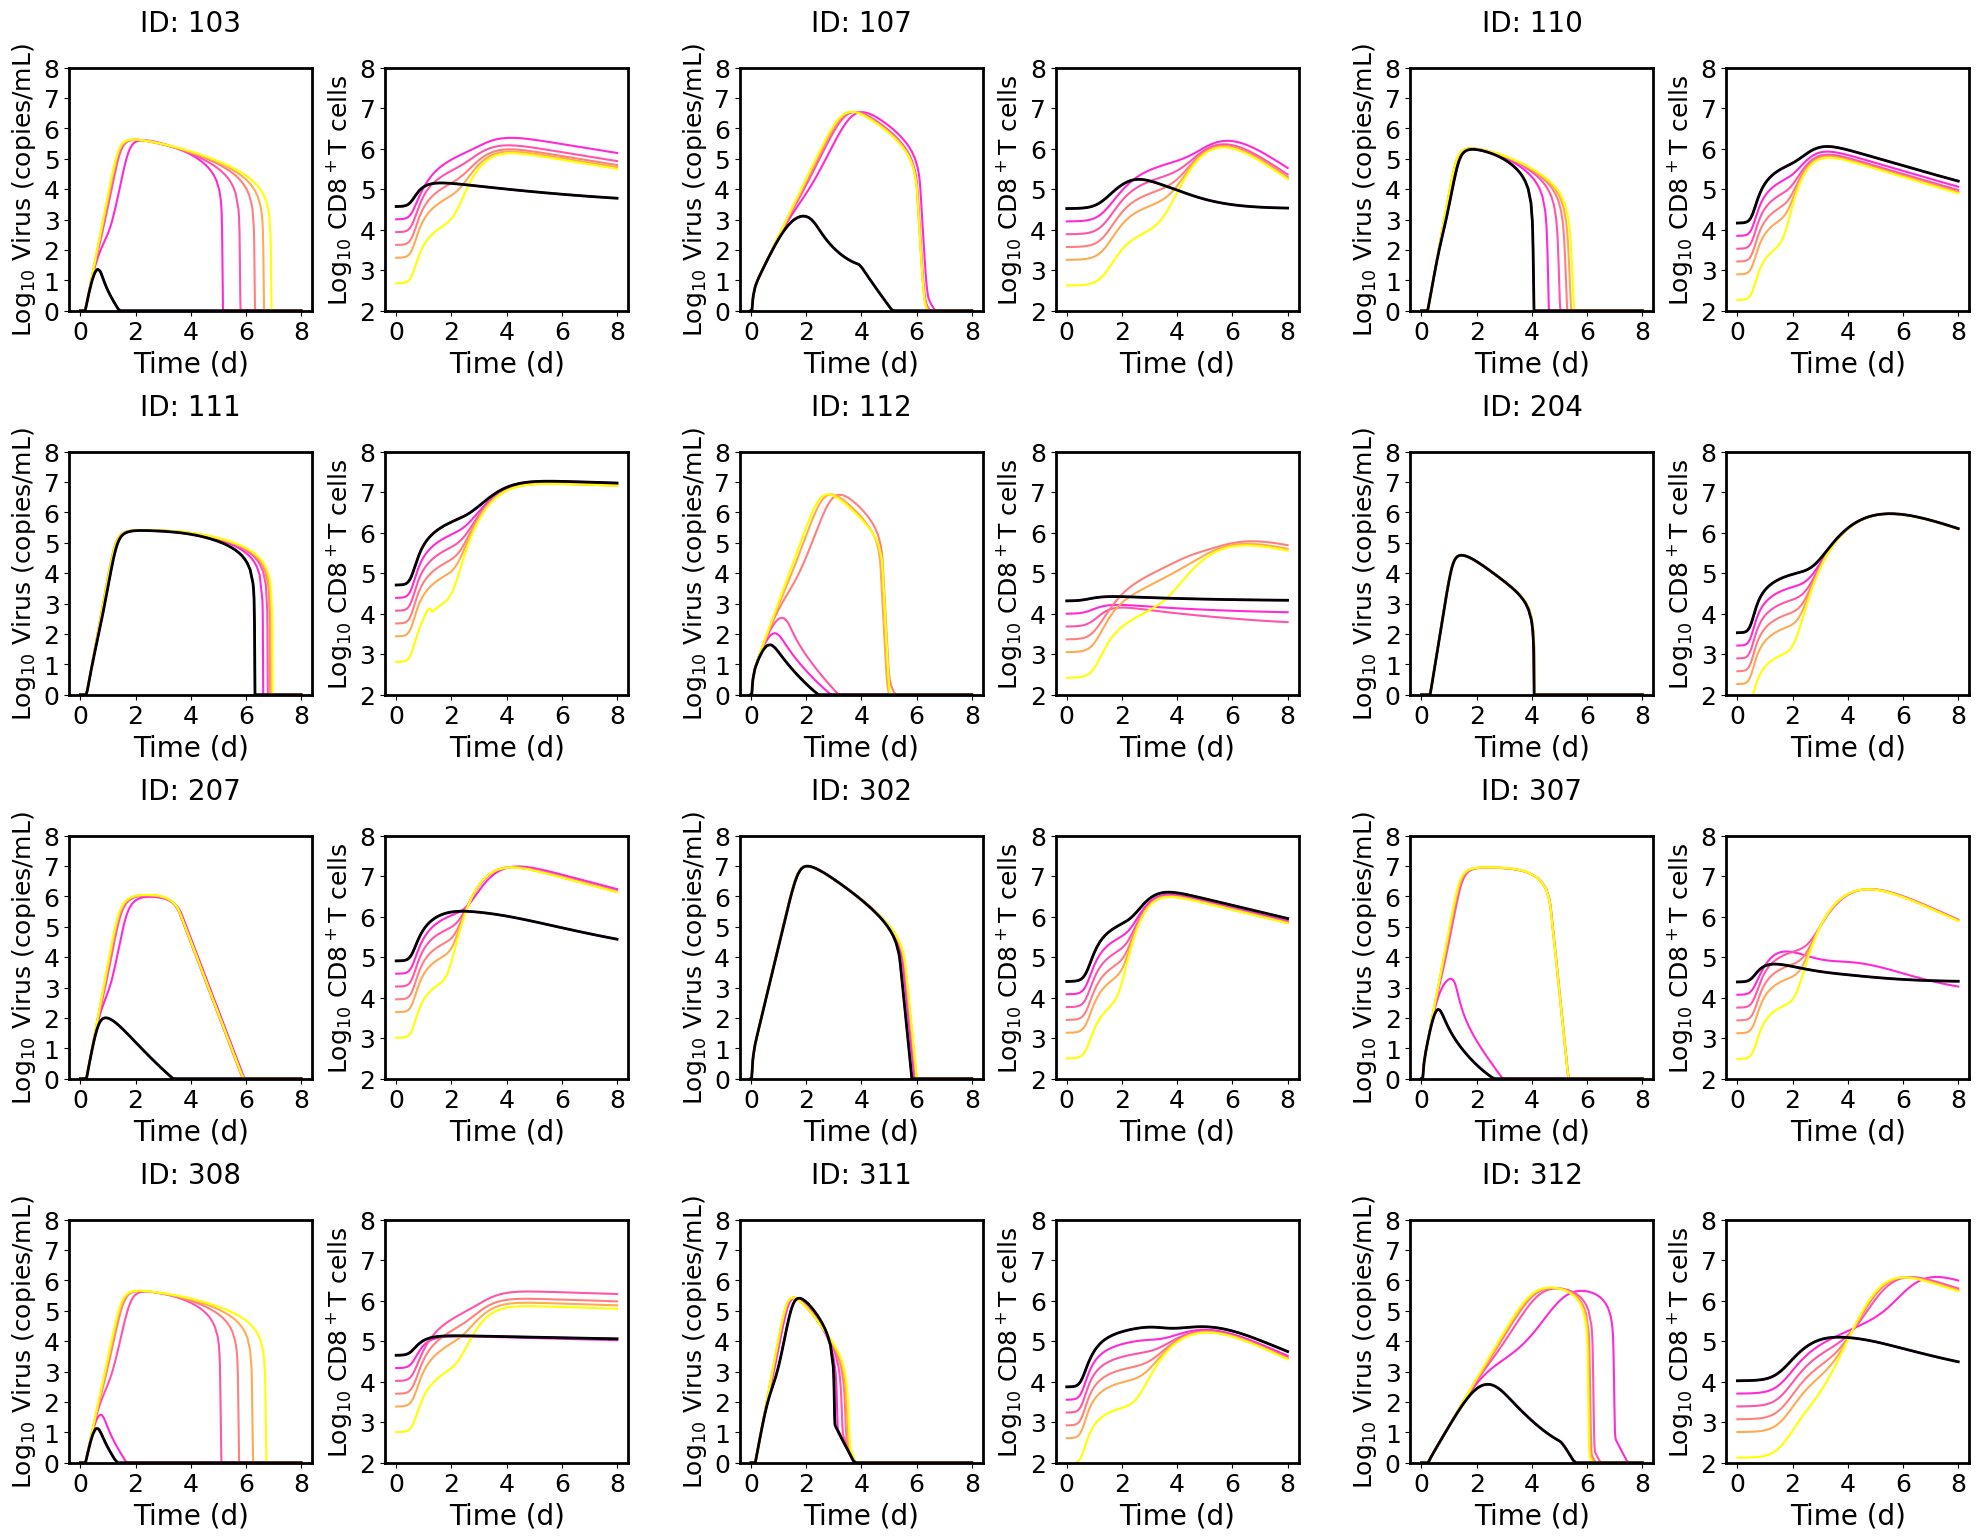

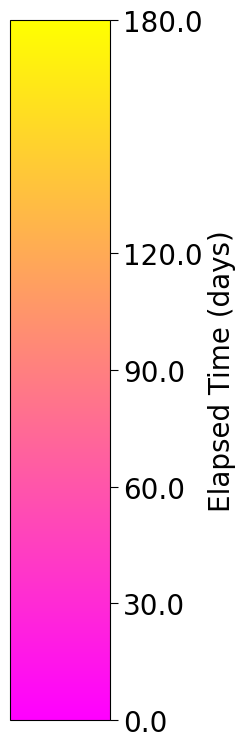

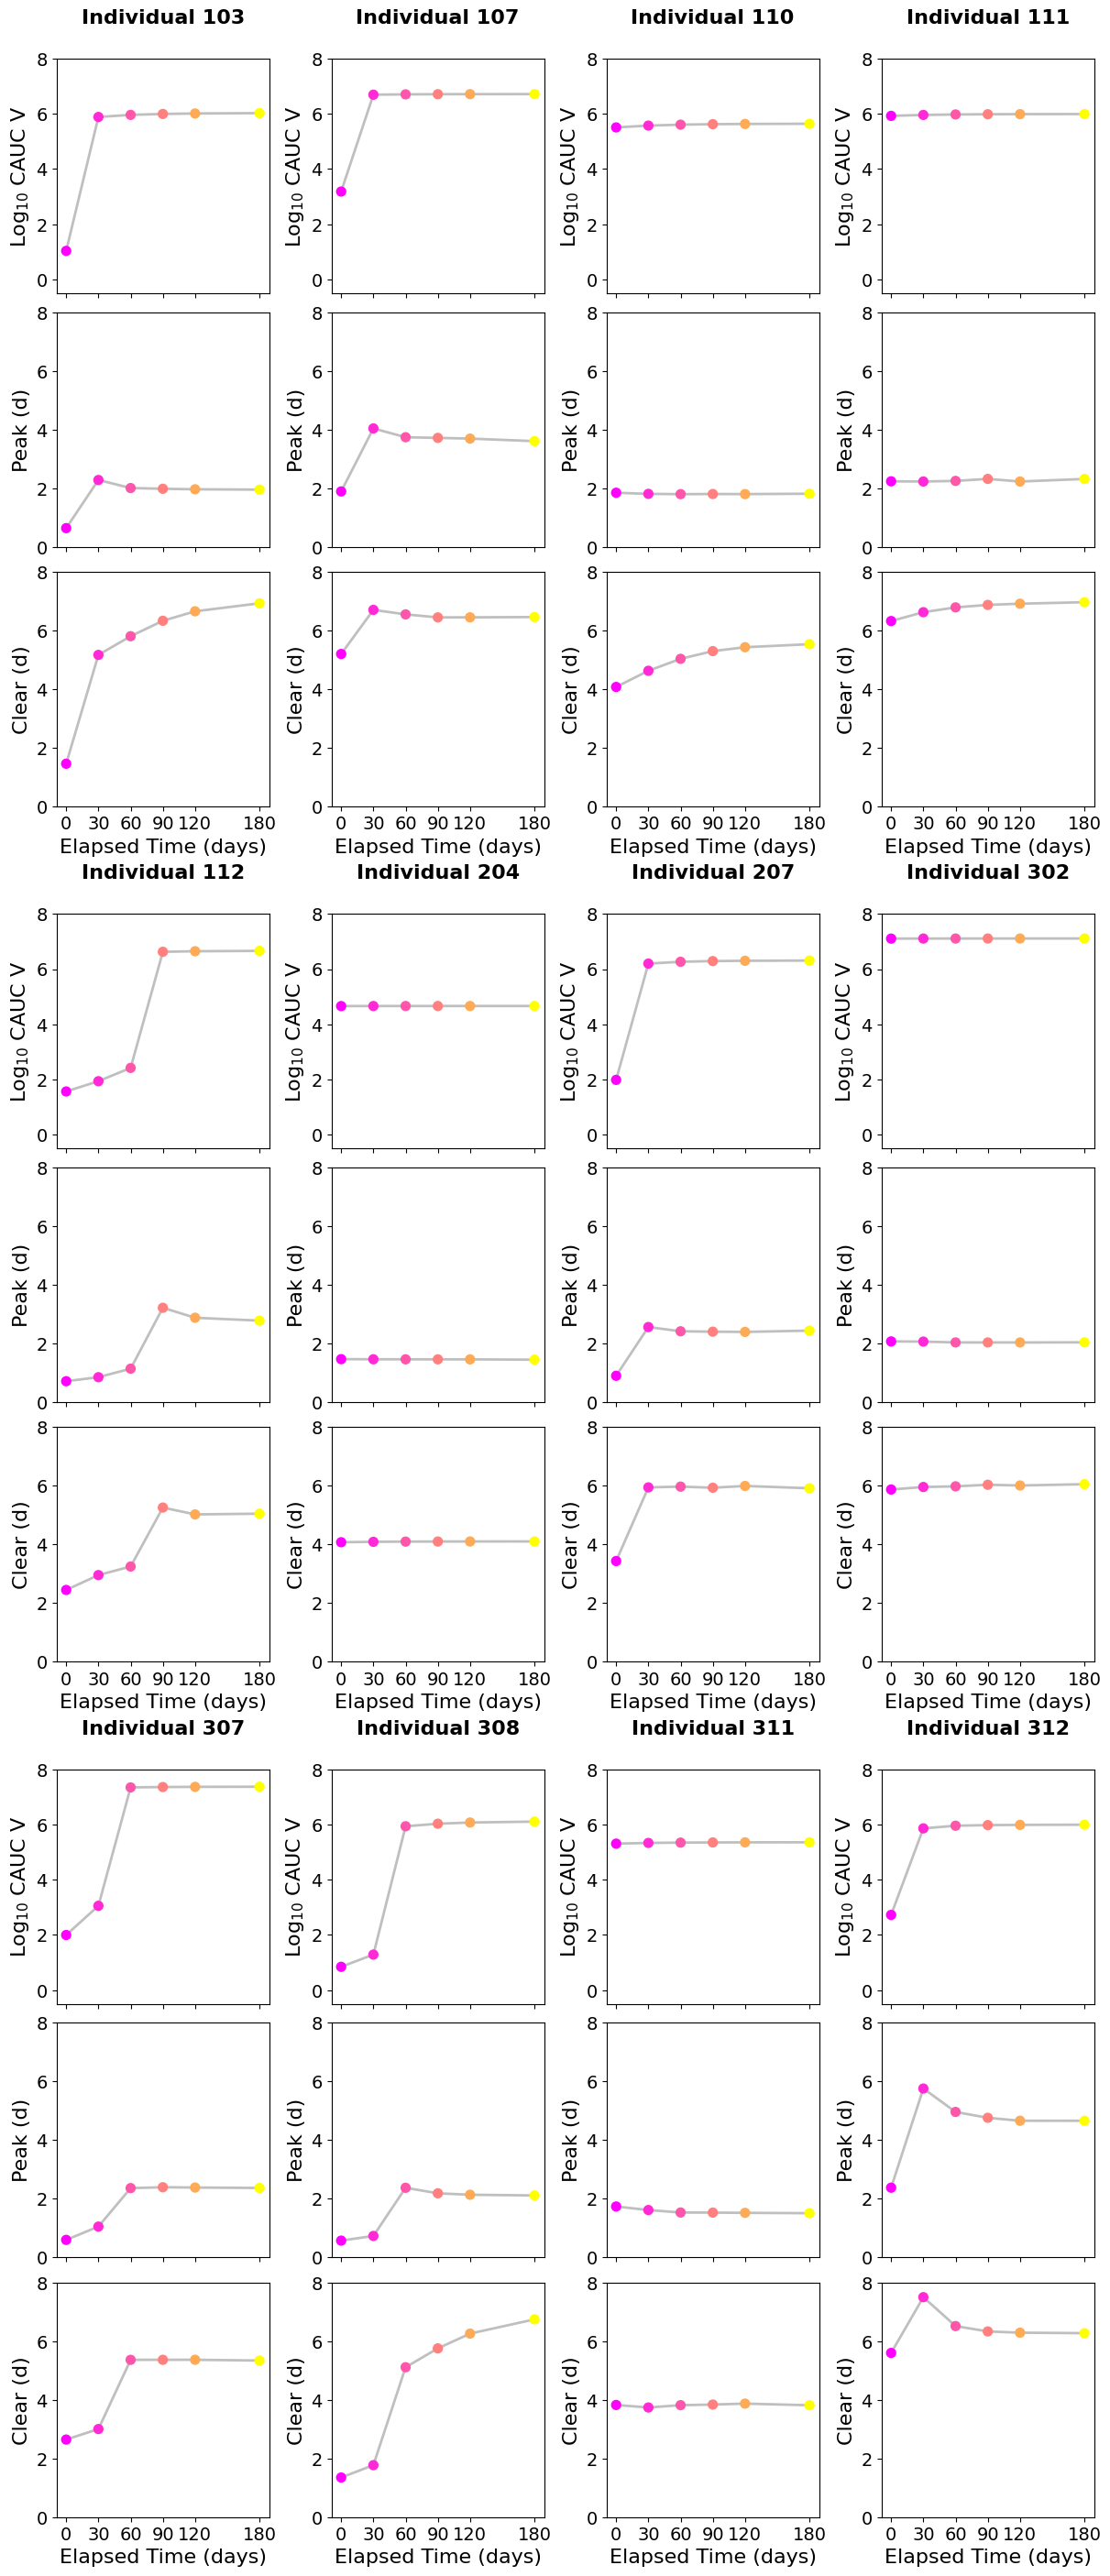

In [37]:
import os
os.environ["JULIA_NUM_THREADS"] = "1"
import sys
from julia.api import Julia
julia = Julia(sysimage="sysimage_env/sysimage.so")
from julia import Main

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import re, math

# -----------------------------------------------------------------------------
# Include the Julia model
# -----------------------------------------------------------------------------
Main.include("models/Reinfection_model.jl")

# -----------------------------------------------------------------------------
# Helper functions
# -----------------------------------------------------------------------------
def format_fit_params(fit_parameter):
    if isinstance(fit_parameter, list) and len(fit_parameter) > 1:
        fit_params_str = " ".join(fit_parameter)
    else:
        fit_params_str = fit_parameter[0] if isinstance(fit_parameter, list) else fit_parameter
    replacements = {
        r"\bd_E\b": "dE",
        r"\bdelta\b": "δ",
        r"\bdelta_E\b": "δE",
        r"\bK_delta_E\b": "K(δE)",
        r"\btau\b": "τ",
        r"\bxi\b": "ξ",
        r"\bbeta\b": "β",
        r"\bdelta_E/K_delta_E\b": "Log10 [δE/KδE]",
        r"\bdelta/delta_E\b": "δ/δE",
        r"\beta\b": "η",
        r"\bzeta\b": "ζ",
        r"\btau_memory\b": "τm",
    }
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)
    return fit_params_str

def custom_sci_formatter(x, pos):
    s = f"{x:.1e}"
    s = s.replace("e+0", "e+").replace("e-0", "e-")
    return s

# -----------------------------------------------------------------------------
# Run simulation with exponential decay of ME
# -----------------------------------------------------------------------------
def run_simulation_decay(t_span, y0, base_params, day_list, decay_rate):
    solutions = []
    cauc_values, peak_days, clear_days = [], [], []
    for day in day_list:
        decayed_ME = base_params["ME"] * np.exp(-decay_rate * day)
        y0_local = y0.copy()
        y0_local[0] = float(base_params["T0"])
        y0_local[5] = decayed_ME  # ME is at index 5
        params_julia = [
            float(np.float64(base_params["beta"])),
            float(np.float64(base_params["k"])),
            float(np.float64(base_params["p"])),
            float(np.float64(base_params["c"])),
            float(np.float64(base_params["delta"])),
            float(np.float64(base_params["xi"])),
            float(np.float64(base_params["a"])),
            float(np.float64(base_params["d_E"])),
            float(np.float64(base_params["delta_E"])),
            float(np.float64(base_params["K_delta_E"])),
            float(np.float64(base_params["zeta"])),
            float(np.float64(base_params["eta"])),
            float(np.float64(base_params["K_I1"])),
            float(np.float64(base_params["tau_memory"])),
            float(np.float64(base_params["damp"]))
        ]
        t_values, y_values = Main.tmap_ReinfectionModel(t_span, y0_local, params_julia)
        sol = {"t": np.array(t_values, dtype=np.float64),
               "y": np.array(y_values, dtype=np.float64),
               "day": day,
               "decayed_ME": decayed_ME}
        solutions.append(sol)
        
        # Compute metrics for sensitivity.
        t_arr = sol["t"]
        virus = sol["y"][3, :]
        auc = np.trapezoid(virus, t_arr)
        cauc_values.append(auc)
        peak_idx = np.argmax(virus)
        peak_days.append(t_arr[peak_idx])
        clear_time = np.nan
        for i in range(peak_idx+1, len(t_arr)):
            if virus[i] < 1:
                clear_time = t_arr[i]
                break
        clear_days.append(clear_time)
        
    # Baseline simulation (with T0 = 4E7 and original ME)
    y0_baseline = y0.copy()
    y0_baseline[0] = 4E7
    y0_baseline[5] = base_params["ME"]
    baseline_params_list = [
            float(np.float64(base_params["beta"])),
            float(np.float64(base_params["k"])),
            float(np.float64(base_params["p"])),
            float(np.float64(base_params["c"])),
            float(np.float64(base_params["delta"])),
            float(np.float64(base_params["xi"])),
            float(np.float64(base_params["a"])),
            float(np.float64(base_params["d_E"])),
            float(np.float64(base_params["delta_E"])),
            float(np.float64(base_params["K_delta_E"])),
            float(np.float64(base_params["zeta"])),
            float(np.float64(base_params["eta"])),
            float(np.float64(base_params["K_I1"])),
            float(np.float64(base_params["tau_memory"])),
            float(np.float64(base_params["damp"]))
        ]
    t_baseline, y_baseline = Main.tmap_ReinfectionModel(t_span, y0_baseline, baseline_params_list)
    baseline = {"t": np.array(t_baseline, dtype=np.float64),
                "y": np.array(y_baseline, dtype=np.float64)}
    
    sim_data = {
        "day_list": np.array(day_list, dtype=np.float64),
        "solutions": solutions,
        "baseline": baseline,
        "cauc_values": np.array(cauc_values, dtype=np.float64),
        "peak_days": np.array(peak_days, dtype=np.float64),
        "clear_days": np.array(clear_days, dtype=np.float64),
        "base_ME": base_params["ME"]
    }
    return sim_data

# -----------------------------------------------------------------------------
# Plotting functions for dynamics and metrics (using elapsed days as x-axis)
# -----------------------------------------------------------------------------
def plot_individual_dynamics_decay(fig, cell_gs, sim_data, t_span, Zero_conditions, indiv_id):
    gs_dyn = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=cell_gs, wspace=0.3)
    ax_virus = fig.add_subplot(gs_dyn[0])
    ax_effector = fig.add_subplot(gs_dyn[1])
    
    # Style spines.
    for spine in ax_virus.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    for spine in ax_effector.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    
    day_list = sim_data["day_list"]
    solutions = sim_data["solutions"]
    cmap = plt.get_cmap("spring")
    norm_days = mpl.colors.Normalize(vmin=min(day_list), vmax=max(day_list))
    
    # Plot simulation traces for each elapsed day.
    for sol in solutions:
        day = sol["day"]
        color = cmap(norm_days(day))
        ax_virus.plot(sol["t"], np.log10(np.maximum(sol["y"][3, :], 1)),
                      color=color, linewidth=1.5)
        ax_effector.plot(sol["t"], np.log10(np.maximum(sol["y"][4, :] + sol["y"][5, 0], 1)),
                         color=color, linewidth=1.5)
    
    # Plot the baseline (black bold line).
    baseline = sim_data["baseline"]
    ax_virus.plot(baseline["t"], np.log10(np.maximum(baseline["y"][3, :], 1)),
                  color='black', linewidth=2)
    ax_effector.plot(baseline["t"], np.log10(np.maximum(baseline["y"][4, :] + Zero_conditions["ME"], 1)),
                     color='black', linewidth=2)
    
    # Set ticks and labels.
    ax_virus.set_yticks(np.arange(0, 9, 1))
    ax_effector.set_yticks(np.arange(2, 9, 1))
    ax_virus.set_xticks([0, 2, 4, 6, 8])
    ax_effector.set_xticks([0, 2, 4, 6, 8])
    ax_virus.set_ylabel('Log$_{10}$ Virus (copies/mL)', fontsize=18)
    ax_effector.set_ylabel('Log$_{10}$ CD8$^+$T cells', fontsize=18)
    ax_virus.set_xlabel("Time (d)", fontsize=20)
    ax_effector.set_xlabel("Time (d)", fontsize=20)
    ax_virus.tick_params(labelsize=18)
    ax_effector.tick_params(labelsize=18)
    ax_virus.set_ylim(0, 8)
    ax_effector.set_ylim(2, 8)
    ax_virus.set_box_aspect(1)
    ax_effector.set_box_aspect(1)
    
    ax_virus.text(0.5, 1.15, f"ID: {indiv_id}",
                  transform=ax_virus.transAxes, fontsize=20, ha='center')

def plot_individual_metrics_decay(fig, cell_gs, sim_data, indiv_id):
    gs_met = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=cell_gs, hspace=0)
    ax_auc   = fig.add_subplot(gs_met[0])
    ax_peak  = fig.add_subplot(gs_met[1], sharex=ax_auc)
    ax_clear = fig.add_subplot(gs_met[2], sharex=ax_auc)
    
    plt.setp(ax_auc.get_xticklabels(), visible=False)
    plt.setp(ax_peak.get_xticklabels(), visible=False)
    
    days = sim_data["day_list"]
    x_metric = days
    auc_metric = np.log10(sim_data["cauc_values"])
    peak_metric = sim_data["peak_days"]
    clear_metric = sim_data["clear_days"]
    
    cmap = plt.get_cmap("spring")
    norm_days = mpl.colors.Normalize(vmin=min(days), vmax=max(days))
    marker_colors = [cmap(norm_days(day)) for day in days]
    
    ax_auc.scatter(x_metric, auc_metric, color=marker_colors, zorder=5, s=50)
    ax_auc.plot(x_metric, auc_metric, color='gray', linewidth=2, alpha=0.5)
    
    ax_peak.scatter(x_metric, peak_metric, color=marker_colors, zorder=5, s=50)
    ax_peak.plot(x_metric, peak_metric, color='gray', linewidth=2, alpha=0.5)
    
    ax_clear.scatter(x_metric, clear_metric, color=marker_colors, zorder=5, s=50)
    ax_clear.plot(x_metric, clear_metric, color='gray', linewidth=2, alpha=0.5)
    
    ax_clear.set_xlabel("Elapsed Time (days)", fontsize=16)
    
    ax_auc.set_ylim(-0.5, 8)
    ax_peak.set_ylim(0, 8)
    ax_clear.set_ylim(0, 8)
    
    # Set x ticks only where scatter points are and label these values as whole numbers
    ax_auc.set_xticks(x_metric)
    ax_auc.set_xticklabels([int(day) for day in x_metric], fontsize=14)
    ax_peak.set_xticks(x_metric)
    ax_peak.set_xticklabels([int(day) for day in x_metric], fontsize=14)
    ax_clear.set_xticks(x_metric)
    ax_clear.set_xticklabels([int(day) for day in x_metric], fontsize=14)

    for ax in (ax_auc, ax_peak, ax_clear):
        ax.tick_params(axis='y', labelsize=14)
        
    ax_auc.set_ylabel("Log$_{10}$ CAUC V", fontsize=16)
    ax_peak.set_ylabel("Peak (d)", fontsize=16)
    ax_clear.set_ylabel("Clear (d)", fontsize=16)
    ax_auc.text(0.5, 1.15, f"Individual {indiv_id}",
                transform=ax_auc.transAxes, fontsize=16, ha='center', fontweight='bold')

def create_global_colorbar_decay(fig, sim_data):
    days = sim_data["day_list"]
    cmap = plt.get_cmap("spring")
    norm_days = mpl.colors.Normalize(vmin=min(days), vmax=max(days))
    cbar_ax = fig.add_axes([0.25, 0.15, 0.1, 0.7])
    cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm_days, orientation='vertical')
    cbar.set_ticks(days)
    cbar.set_ticklabels([f"{day}" for day in days])
    cbar.ax.tick_params(labelsize=20, which='both', length=6)
    cbar.ax.set_ylabel("Elapsed Time (days)", fontsize=20)

# -----------------------------------------------------------------------------
# Load patient parameters and (optional) clinical data
# -----------------------------------------------------------------------------
params = pd.read_excel("Rechallenge.xlsx")
ids = params[params['id'] != 'Population']['id'].unique()

patient_color_names = ['gray', 'purple', 'magenta', 'red', 'goldenrod', 'darkorange',
                       'saddlebrown', 'mediumblue', 'dodgerblue', 'turquoise', 'darkgreen', 'lawngreen']
patient_colors = {}
for pid, cname in zip(ids, patient_color_names):
    rgba = mcolors.to_rgba(cname)
    patient_colors[pid] = {'matplotlib': rgba,
                           'plotly': mpl.colors.to_hex(rgba, keep_alpha=False)}

# Optional: load clinical data for comparison.
df_Rahil = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx")
df_Rahil = df_Rahil[['VOLUNTEER', 'DAY', 'V', 'TSS', 'CD8TE', 'CD8TM', 'COHORT']]
df_Rahil = df_Rahil[(df_Rahil['DAY'] < 9) & (df_Rahil['DAY'] >= 0)]
df_Rahil = df_Rahil[df_Rahil['VOLUNTEER'].isin(ids)]

# -----------------------------------------------------------------------------
# Simulation settings
# -----------------------------------------------------------------------------
t_span = (0.0, 8)
y0_master = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0]*13

# Settings for exponential decay of ME
decay_rate = 0.0243
day_list = [0, 30, 60, 90, 120, 180]

# -----------------------------------------------------------------------------
# Run simulations for each individual (sweeping over elapsed time)
# -----------------------------------------------------------------------------
sim_data_dict = {}
for indiv_id in ids:
    row = params[params['id'] == indiv_id].iloc[0]
    base_params = {
        "T0": row['T0'],
        "beta": row['beta'],
        "k": row['k'],
        "p": row['p'],
        "c": row['c'],
        "delta": row['delta'],
        "xi": row['xi'],
        "a": row['a'],
        "d_E": row['d_E'],
        "delta_E": row['delta_E'],
        "K_delta_E": row['K_delta_E'],
        "zeta": row['zeta'],
        "eta": row['eta'],
        "K_I1": row['K_I1'],
        "tau_memory": row['tau_memory'],
        "damp": row['damp'],
        "ME": row['ME']
    }
    Zero_conditions = {"ME": row['ME'], "M0": row['M0']}
    y0_local = y0_master.copy()
    sim_data = run_simulation_decay(t_span, y0_local, base_params, day_list, decay_rate)
    sim_data_dict[indiv_id] = (sim_data, Zero_conditions)

# -----------------------------------------------------------------------------
# Dynamics Figure (grid of individuals)
# -----------------------------------------------------------------------------
n_indiv = len(ids)
n_cols = 3
n_rows = math.ceil(n_indiv / n_cols)
fig_dyn = plt.figure(figsize=(20, 16))
outer_gs_dyn = gridspec.GridSpec(n_rows, n_cols, figure=fig_dyn)
for i, indiv_id in enumerate(ids):
    cell_gs = outer_gs_dyn[i]
    sim_data, Zero_conditions = sim_data_dict[indiv_id]
    plot_individual_dynamics_decay(fig_dyn, cell_gs, sim_data, t_span, Zero_conditions, indiv_id)
plt.subplots_adjust(left=0.03, right=0.98, top=0.95, bottom=0.03)
plt.show()

# -----------------------------------------------------------------------------
# Global Colorbar Figure
# -----------------------------------------------------------------------------
fig_cbar = plt.figure(figsize=(10, 10))
rep_sim = sim_data_dict[ids[0]][0]
create_global_colorbar_decay(fig_cbar, rep_sim)
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.show()

# -----------------------------------------------------------------------------
# Metrics Figure (grid of individuals)
# -----------------------------------------------------------------------------
n_cols_met = 4
n_rows_met = math.ceil(n_indiv / n_cols_met)
fig_met = plt.figure(figsize=(12, 28), constrained_layout=True)
outer_gs_met = gridspec.GridSpec(n_rows_met, n_cols_met, figure=fig_met, wspace=0.05, hspace=0.05)
for i, indiv_id in enumerate(ids):
    cell_gs = outer_gs_met[i]
    sim_data, _ = sim_data_dict[indiv_id]
    plot_individual_metrics_decay(fig_met, cell_gs, sim_data, indiv_id)
plt.show()


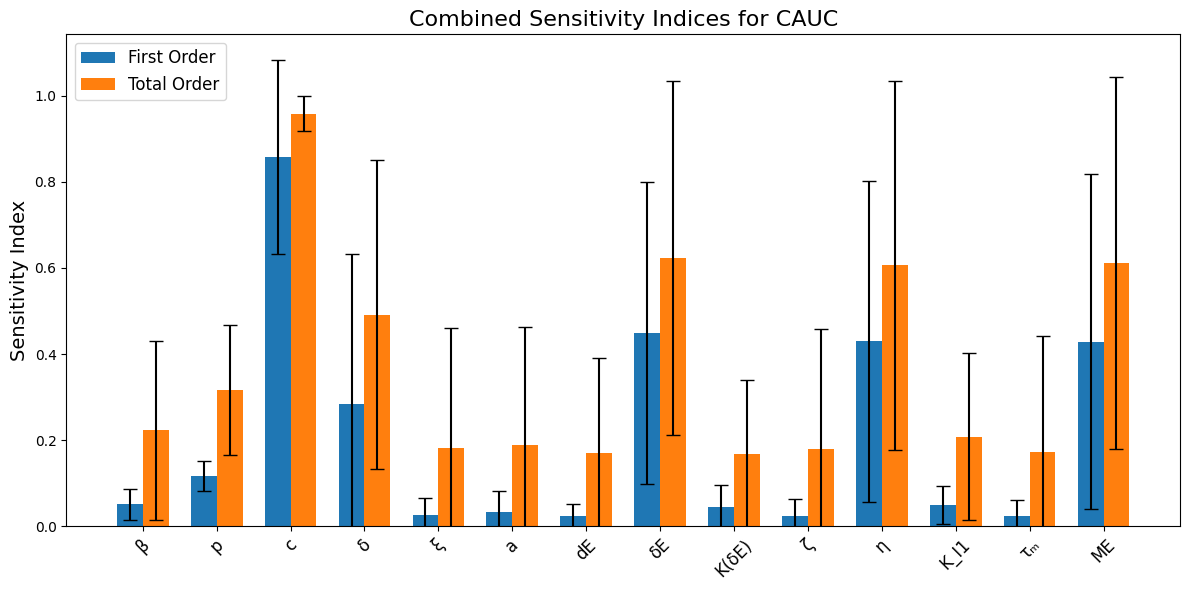

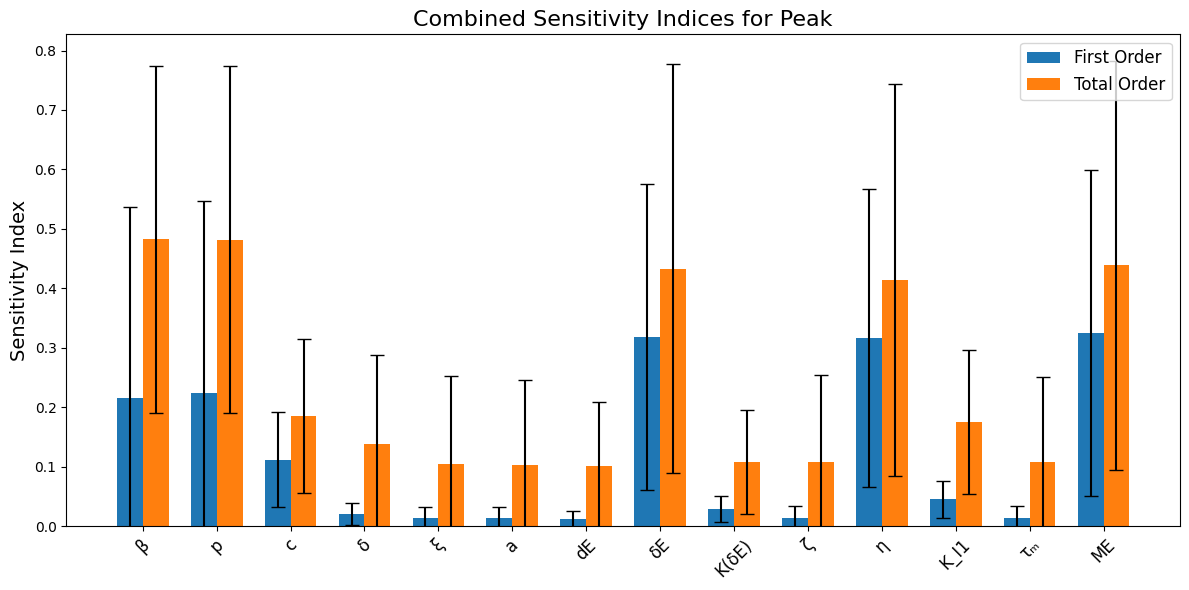

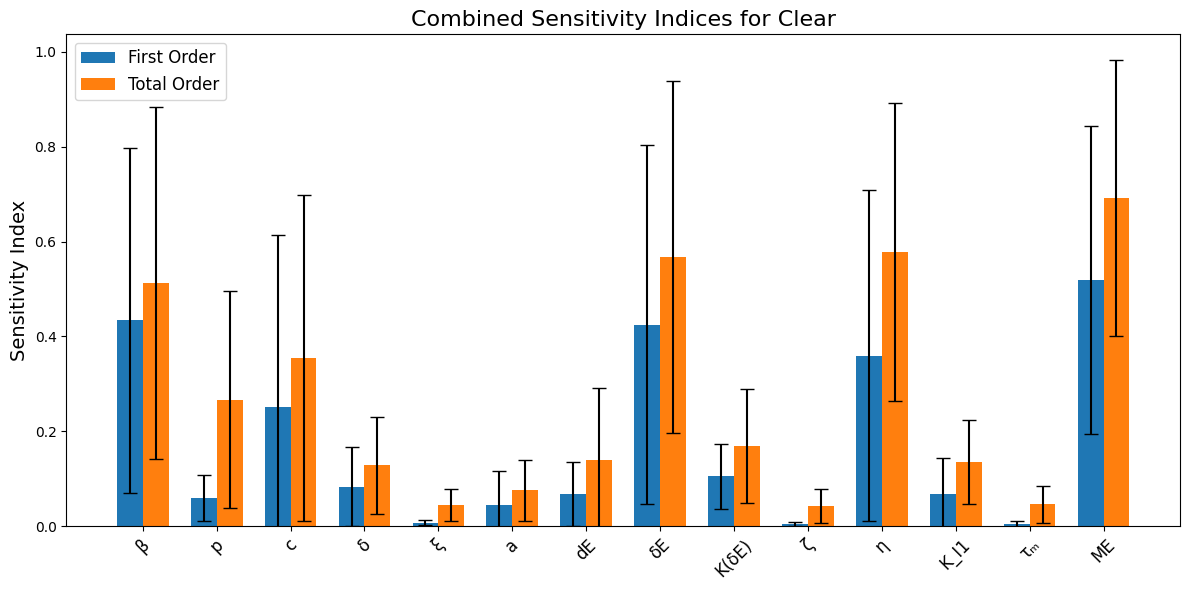

In [2]:
import os
os.environ["JULIA_NUM_THREADS"] = "1"
import sys
from julia.api import Julia
julia = Julia(sysimage="sysimage_env/sysimage.so")
from julia import Main

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import re, math

# Import SALib for FAST sampling and analysis
from SALib.sample import fast_sampler
from SALib.analyze import fast as fast_analyze

# -----------------------------------------------------------------------------
# Include the Julia model.
# -----------------------------------------------------------------------------
Main.include("models/Reinfection_model.jl")

# -----------------------------------------------------------------------------
# Helper: Format parameter names for pretty printing.
# -----------------------------------------------------------------------------
def format_fit_params(fit_parameter):
    if isinstance(fit_parameter, list) and len(fit_parameter) > 1:
        fit_params_str = " ".join(fit_parameter)
    else:
        fit_params_str = fit_parameter[0] if isinstance(fit_parameter, list) else fit_parameter
    replacements = {
        r"\bd_E\b": "dE",
        r"\bdelta\b": "δ",
        r"\bdelta_E\b": "δE",
        r"\bK_delta_E\b": "K(δE)",
        r"\btau\b": "τ",
        r"\bxi\b": "ξ",
        r"\bbeta\b": "β",
        r"\bdelta_E/K_delta_E\b": "Log10 [δE/KδE]",
        r"\bdelta/delta_E\b": "δ/δE",
        r"\beta\b": "η",
        r"\bzeta\b": "ζ",
        r"\btau_memory\b": "τₘ",
    }
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)
    return fit_params_str

# -----------------------------------------------------------------------------
# Define the parameters to be swept.
# -----------------------------------------------------------------------------
params_to_sweep = ["beta", "p", "c", "delta", "xi", "a", "d_E", "delta_E",
                   "K_delta_E", "zeta", "eta", "K_I1", "tau_memory", "ME"]

# -----------------------------------------------------------------------------
# Model wrapper for SALib.
#
# Given a sample vector (one row from SALib’s sample matrix), update the base
# parameter set accordingly, run the simulation via Julia, and compute:
#    • CAUC (area under virus curve)
#    • Peak Day (day of maximum virus)
#    • Clear Day (first day post–peak when virus < 1)
# -----------------------------------------------------------------------------
def model_wrapper(sample, base_params, y0, t_span):
    local_params = base_params.copy()
    for i, param in enumerate(params_to_sweep):
        local_params[param] = sample[i]
    y0_local = y0.copy()
    y0_local[0] = float(base_params["T0"])
    # Use the (updated) ME value.
    y0_local[5] = local_params["ME"]
    params_julia = [
        float(np.float64(local_params["beta"])),
        float(np.float64(local_params["k"])),
        float(np.float64(local_params["p"])),
        float(np.float64(local_params["c"])),
        float(np.float64(local_params["delta"])),
        float(np.float64(local_params["xi"])),
        float(np.float64(local_params["a"])),
        float(np.float64(local_params["d_E"])),
        float(np.float64(local_params["delta_E"])),
        float(np.float64(local_params["K_delta_E"])),
        float(np.float64(local_params["zeta"])),
        float(np.float64(local_params["eta"])),
        float(np.float64(local_params["K_I1"])),
        float(np.float64(local_params["tau_memory"])),
        float(np.float64(local_params["damp"]))
    ]
    t_values, y_values = Main.tmap_ReinfectionModel(t_span, y0_local, params_julia)
    t_arr = np.array(t_values, dtype=np.float64)
    y_arr = np.array(y_values, dtype=np.float64)
    virus = y_arr[3, :]
    auc = np.trapezoid(virus, t_arr)
    peak_idx = np.argmax(virus)
    peak_day = t_arr[peak_idx]
    clear_day = np.nan
    for j in range(peak_idx+1, len(t_arr)):
        if virus[j] < 1:
            clear_day = t_arr[j]
            break
    return np.array([auc, peak_day, clear_day])

# -----------------------------------------------------------------------------
# Simulation settings.
# -----------------------------------------------------------------------------
t_span = (0.0, 8)
y0_master = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0]*13
sweep_percent = 50  # ±50% variation for each parameter

# -----------------------------------------------------------------------------
# Load individual parameter sets.
# -----------------------------------------------------------------------------
params_df = pd.read_excel("Rechallenge.xlsx")
ids = params_df[params_df['id'] != 'Population']['id'].unique()

# Create unique colors for each individual.
patient_color_names = ['gray', 'purple', 'magenta', 'red', 'goldenrod', 'darkorange',
                       'saddlebrown', 'mediumblue', 'dodgerblue', 'turquoise', 'darkgreen', 'lawngreen']
patient_colors = {}
for i, pid in enumerate(ids):
    color_name = patient_color_names[i % len(patient_color_names)]
    patient_colors[pid] = mcolors.to_rgba(color_name)

# -----------------------------------------------------------------------------
# Run FAST sensitivity for each individual.
#
# For each individual we:
#   • Define a SALib “problem” where each parameter’s bounds are ±50% of its base.
#   • Use FAST sampling to generate parameter sets.
#   • Evaluate the model (returning [CAUC, Peak, Clear]) at each sample.
#   • Analyze the outputs (for each metric) to obtain S1 (first order) and ST (total order)
# -----------------------------------------------------------------------------
# We'll store results per individual in:
#   indiv_results[id][metric] = {"S1": array, "ST": array} for metric in [CAUC, Peak, Clear]
indiv_results = {}

# FAST settings
N = 65  # sample size (adjust as needed)

for indiv_id in ids:
    row = params_df[params_df['id'] == indiv_id].iloc[0]
    base_params = {
        "T0": row['T0'],
        "beta": row['beta'],
        "k": row['k'],
        "p": row['p'],
        "c": row['c'],
        "delta": row['delta'],
        "xi": row['xi'],
        "a": row['a'],
        "d_E": row['d_E'],
        "delta_E": row['delta_E'],
        "K_delta_E": row['K_delta_E'],
        "zeta": row['zeta'],
        "eta": row['eta'],
        "K_I1": row['K_I1'],
        "tau_memory": row['tau_memory'],
        "damp": row['damp'],
        "ME": row['ME']
    }
    # Define parameter bounds for each parameter (±50%).
    bounds = []
    for param in params_to_sweep:
        base_val = base_params[param]
        lower = base_val * (1 - sweep_percent/100)
        upper = base_val * (1 + sweep_percent/100)
        bounds.append([lower, upper])
    problem = {
        'num_vars': len(params_to_sweep),
        'names': params_to_sweep,
        'bounds': bounds
    }
    # Generate samples using FAST.
    param_values = fast_sampler.sample(problem, N)
    # Evaluate the model for each sample.
    Y = []  # each row: [CAUC, Peak, Clear]
    for sample in param_values:
        try:
            result = model_wrapper(sample, base_params, y0_master.copy(), t_span)
        except Exception as e:
            result = np.array([np.nan, np.nan, np.nan])
        Y.append(result)
    Y = np.array(Y)
    # For each metric, run FAST sensitivity analysis.
    indiv_results[indiv_id] = {}
    metric_names = ["CAUC", "Peak", "Clear"]
    for i, metric in enumerate(metric_names):
        Y_metric = Y[:, i]
        Si = fast_analyze.analyze(problem, Y_metric, print_to_console=False)
        # Si['S1'] and Si['ST'] are arrays for our 14 parameters.
        indiv_results[indiv_id][metric] = {"S1": Si["S1"], "ST": Si["ST"]}

# -----------------------------------------------------------------------------
# Aggregate sensitivity indices across individuals.
#
# For each metric and each parameter, we collect the indices (from each individual)
# and then compute the mean and standard deviation.
# -----------------------------------------------------------------------------
aggregated = {metric: {param: {"S1": [], "ST": []} for param in params_to_sweep} 
              for metric in ["CAUC", "Peak", "Clear"]}

for indiv_id in ids:
    for metric in ["CAUC", "Peak", "Clear"]:
        S1_array = indiv_results[indiv_id][metric]["S1"]
        ST_array = indiv_results[indiv_id][metric]["ST"]
        for i, param in enumerate(params_to_sweep):
            aggregated[metric][param]["S1"].append(S1_array[i])
            aggregated[metric][param]["ST"].append(ST_array[i])

agg_means = {metric: {"S1": [], "ST": []} for metric in ["CAUC", "Peak", "Clear"]}
agg_stds = {metric: {"S1": [], "ST": []} for metric in ["CAUC", "Peak", "Clear"]}
for metric in ["CAUC", "Peak", "Clear"]:
    for param in params_to_sweep:
        s1_vals = np.array(aggregated[metric][param]["S1"])
        st_vals = np.array(aggregated[metric][param]["ST"])
        agg_means[metric]["S1"].append(np.nanmean(s1_vals))
        agg_means[metric]["ST"].append(np.nanmean(st_vals))
        agg_stds[metric]["S1"].append(np.nanstd(s1_vals))
        agg_stds[metric]["ST"].append(np.nanstd(st_vals))

# -----------------------------------------------------------------------------
# Plotting:
# For each metric, produce three figures:
# 1. Combined bar plot (first order and total order together) with y-axis ≥ 0.
# 2. Scatter plot for first-order indices (each individual's point in its unique color).
# 3. Scatter plot for total-order indices (each individual's point in its unique color).
# -----------------------------------------------------------------------------
x = np.arange(len(params_to_sweep))
width = 0.35
metric_names = ["CAUC", "Peak", "Clear"]

for metric in metric_names:
    # Combined bar plot.
    fig, ax = plt.subplots(figsize=(12, 6))
    first_means = agg_means[metric]["S1"]
    first_std   = agg_stds[metric]["S1"]
    total_means = agg_means[metric]["ST"]
    total_std   = agg_stds[metric]["ST"]
    
    ax.bar(x - width/2, first_means, width, yerr=first_std, capsize=5, label="First Order")
    ax.bar(x + width/2, total_means, width, yerr=total_std, capsize=5, label="Total Order")
    ax.set_xticks(x)
    ax.set_xticklabels([format_fit_params([param]) for param in params_to_sweep], rotation=45, fontsize=12)
    ax.set_ylabel("Sensitivity Index", fontsize=14)
    ax.set_title(f"Combined Sensitivity Indices for {metric}", fontsize=16)
    ax.legend(fontsize=12)
    ax.set_ylim(bottom=0)
    plt.tight_layout()
    plt.show()

# Save First Order and Total Order results to CSV
first_order_df = pd.DataFrame({param: [indiv_results[indiv_id]["CAUC"]["S1"][i] for indiv_id in ids] for i, param in enumerate(params_to_sweep)}, index=ids)
first_order_df.to_csv("first_order_sensitivity_reinfection.csv")

total_order_df = pd.DataFrame({param: [indiv_results[indiv_id]["CAUC"]["ST"][i] for indiv_id in ids] for i, param in enumerate(params_to_sweep)}, index=ids)
total_order_df.to_csv("total_order_sensitivity_reinfection.csv")



103 [[np.float64(3.72913395074297e-05), np.float64(0.00011187401852228911)], [np.float64(1.262210263369175), np.float64(3.786630790107525)], [np.float64(88.544429324759), np.float64(265.633287974277)], [np.float64(0.2051179760006325), np.float64(0.6153539280018975)], [np.float64(0.050964228006234), np.float64(0.15289268401870199)], [np.float64(3.61736035873066), np.float64(10.852081076191979)], [np.float64(0.129684812772384), np.float64(0.38905443831715203)], [np.float64(1.922405279451425), np.float64(5.767215838354275)], [np.float64(1226.32373084198), np.float64(3678.97119252594)], [np.float64(0.01119455867050685), np.float64(0.03358367601152055)], [np.float64(0.1306903277527825), np.float64(0.3920709832583475)]]
107 [[np.float64(8.148466179703e-07), np.float64(2.4445398539108998e-06)], [np.float64(3.51828816188927), np.float64(10.55486448566781)], [np.float64(16.4071205513041), np.float64(49.2213616539123)], [np.float64(0.79320603425139), np.float64(2.3796181027541703)], [np.float64(

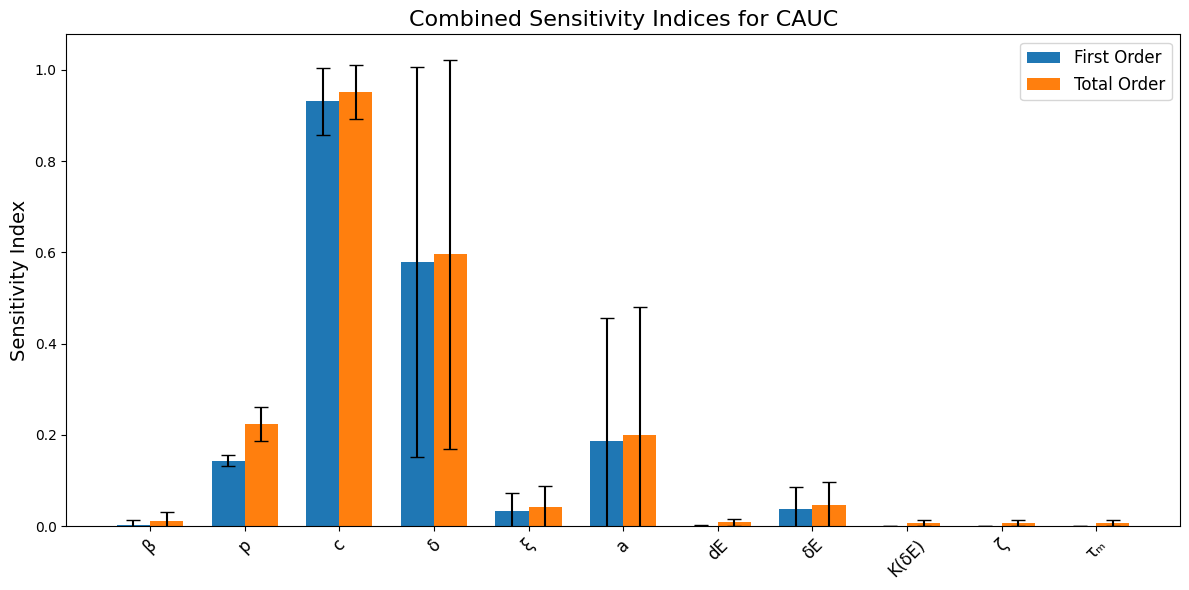

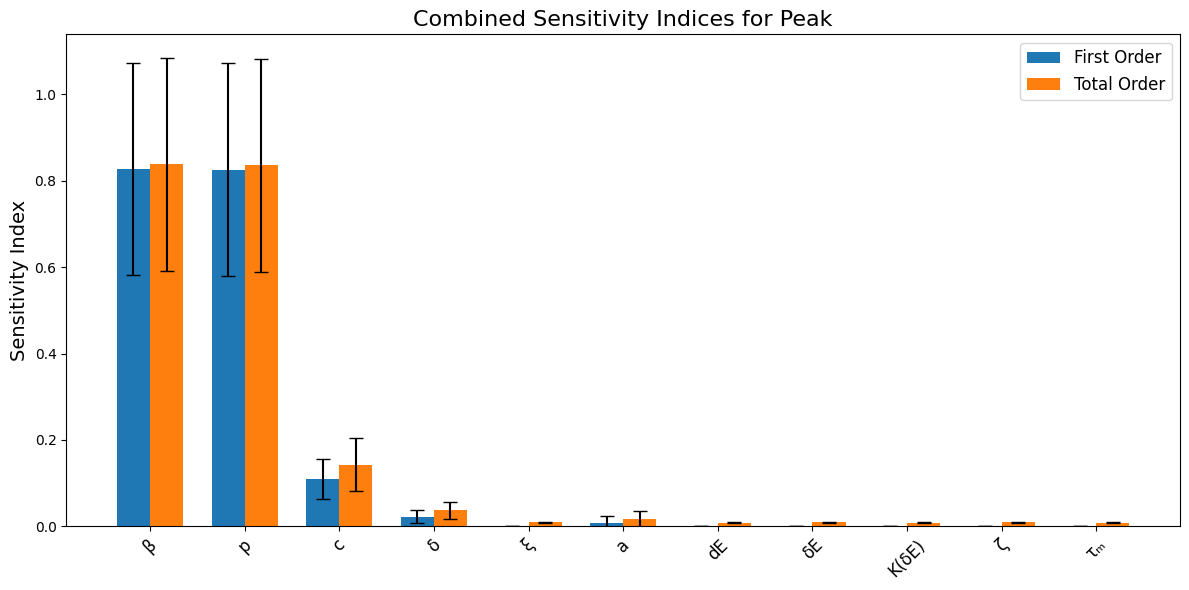

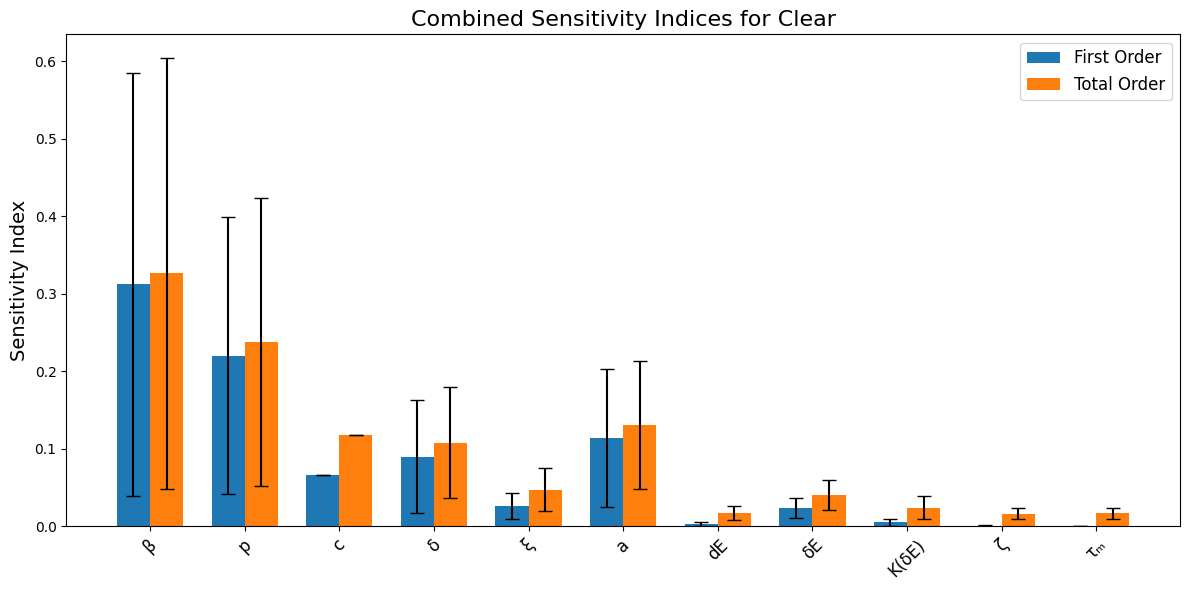

In [9]:

Main.include("models/memory_model.jl")

# -----------------------------------------------------------------------------
# Helper: Format parameter names for pretty printing.
# -----------------------------------------------------------------------------
def format_fit_params(fit_parameter):
    if isinstance(fit_parameter, list) and len(fit_parameter) > 1:
        fit_params_str = " ".join(fit_parameter)
    else:
        fit_params_str = fit_parameter[0] if isinstance(fit_parameter, list) else fit_parameter
    replacements = {
        r"\bd_E\b": "dE",
        r"\bdelta\b": "δ",
        r"\bdelta_E\b": "δE",
        r"\bK_delta_E\b": "K(δE)",
        r"\btau\b": "τ",
        r"\bxi\b": "ξ",
        r"\bbeta\b": "β",
        r"\bdelta_E/K_delta_E\b": "Log10 [δE/KδE]",
        r"\bdelta/delta_E\b": "δ/δE",
        r"\beta\b": "η",
        r"\bzeta\b": "ζ",
        r"\btau_memory\b": "τₘ",
    }
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)
    return fit_params_str

# -----------------------------------------------------------------------------
# Define the parameters to be swept.
# -----------------------------------------------------------------------------
params_to_sweep = ["beta", "p", "c", "delta", "xi", "a", "d_E", "delta_E",
                   "K_delta_E", "zeta", "tau_memory"]

# -----------------------------------------------------------------------------
# Model wrapper for SALib.
#
# Given a sample vector (one row from SALib’s sample matrix), update the base
# parameter set accordingly, run the simulation via Julia, and compute:
#    • CAUC (area under virus curve)
#    • Peak Day (day of maximum virus)
#    • Clear Day (first day post–peak when virus < 1)
# -----------------------------------------------------------------------------
def model_wrapper(sample, base_params, y0, t_span):
    local_params = base_params.copy()
    for i, param in enumerate(params_to_sweep):
        local_params[param] = sample[i]
    y0_local = y0.copy()
    y0_local[0] = float(base_params["T0"])

    params_julia = [
        float(np.float64(local_params["beta"])),
        float(np.float64(local_params["k"])),
        float(np.float64(local_params["p"])),
        float(np.float64(local_params["c"])),
        float(np.float64(local_params["delta"])),
        float(np.float64(local_params["xi"])),
        float(np.float64(local_params["a"])),
        float(np.float64(local_params["d_E"])),
        float(np.float64(local_params["delta_E"])),
        float(np.float64(local_params["K_delta_E"])),
        float(np.float64(local_params["zeta"])),
        float(np.float64(local_params["eta"])),
        float(np.float64(local_params["K_I1"])),
        float(np.float64(local_params["tau_memory"])),
    ]
    t_values, y_values = Main.tmap_LCTModel(t_span, y0_local, params_julia)
    t_arr = np.array(t_values, dtype=np.float64)
    y_arr = np.array(y_values, dtype=np.float64)
    virus = y_arr[3, :]
    auc = np.trapezoid(virus, t_arr)
    peak_idx = np.argmax(virus)
    peak_day = t_arr[peak_idx]
    clear_day = np.nan
    for j in range(peak_idx+1, len(t_arr)):
        if virus[j] < 1:
            clear_day = t_arr[j]
            break
    return np.array([auc, peak_day, clear_day])

# -----------------------------------------------------------------------------
# Simulation settings.
# -----------------------------------------------------------------------------
t_span = (0.0, 8)
y0_master = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0]*13
sweep_percent = 50  # ±50% variation for each parameter

# -----------------------------------------------------------------------------
# Load individual parameter sets.
# -----------------------------------------------------------------------------
params_df = pd.read_excel("LCT.xlsx")
ids = params_df[params_df['id'] != 'Population']['id'].unique()

# Create unique colors for each individual.
patient_color_names = ['gray', 'purple', 'magenta', 'red', 'goldenrod', 'darkorange',
                       'saddlebrown', 'mediumblue', 'dodgerblue', 'turquoise', 'darkgreen', 'lawngreen']
patient_colors = {}
for i, pid in enumerate(ids):
    color_name = patient_color_names[i % len(patient_color_names)]
    patient_colors[pid] = mcolors.to_rgba(color_name)

# -----------------------------------------------------------------------------
# Run FAST sensitivity for each individual.
#
# For each individual we:
#   • Define a SALib “problem” where each parameter’s bounds are ±50% of its base.
#   • Use FAST sampling to generate parameter sets.
#   • Evaluate the model (returning [CAUC, Peak, Clear]) at each sample.
#   • Analyze the outputs (for each metric) to obtain S1 (first order) and ST (total order)
# -----------------------------------------------------------------------------
# We'll store results per individual in:
#   indiv_results[id][metric] = {"S1": array, "ST": array} for metric in [CAUC, Peak, Clear]
indiv_results = {}

# FAST settings
N = 65  # sample size (adjust as needed)

for indiv_id in ids:
    row = params_df[params_df['id'] == indiv_id].iloc[0]
    base_params = {
        "T0": row['T0'],
        "beta": row['beta'],
        "k": row['k'],
        "p": row['p'],
        "c": row['c'],
        "delta": row['delta'],
        "xi": row['xi'],
        "a": row['a'],
        "d_E": row['d_E'],
        "delta_E": row['delta_E'],
        "K_delta_E": row['K_delta_E'],
        "zeta": row['zeta'],
        "eta": row['eta'],
        "K_I1": row['K_I1'],
        "tau_memory": row['tau_memory']
    }
    # Define parameter bounds for each parameter (±50%).
    bounds = []
    for param in params_to_sweep:
        base_val = base_params[param]
        lower = base_val * (1 - sweep_percent/100)
        upper = base_val * (1 + sweep_percent/100)
        bounds.append([lower, upper])
    print(indiv_id, bounds)
    problem = {
        'num_vars': len(params_to_sweep),
        'names': params_to_sweep,
        'bounds': bounds
    }
    # Generate samples using FAST.
    param_values = fast_sampler.sample(problem, N)
    # Evaluate the model for each sample.
    Y = []  # each row: [CAUC, Peak, Clear]
    for sample in param_values:
        try:
            result = model_wrapper(sample, base_params, y0_master.copy(), t_span)
        except Exception as e:
            result = np.array([np.nan, np.nan, np.nan])
        Y.append(result)
    Y = np.array(Y)
    # For each metric, run FAST sensitivity analysis.
    indiv_results[indiv_id] = {}
    metric_names = ["CAUC", "Peak", "Clear"]
    for i, metric in enumerate(metric_names):
        Y_metric = Y[:, i]
        Si = fast_analyze.analyze(problem, Y_metric, print_to_console=False)
        # Si['S1'] and Si['ST'] are arrays for our 14 parameters.
        indiv_results[indiv_id][metric] = {"S1": Si["S1"], "ST": Si["ST"]}

# -----------------------------------------------------------------------------
# Aggregate sensitivity indices across individuals.
#
# For each metric and each parameter, we collect the indices (from each individual)
# and then compute the mean and standard deviation.
# -----------------------------------------------------------------------------
aggregated = {metric: {param: {"S1": [], "ST": []} for param in params_to_sweep} 
              for metric in ["CAUC", "Peak", "Clear"]}

for indiv_id in ids:
    for metric in ["CAUC", "Peak", "Clear"]:
        S1_array = indiv_results[indiv_id][metric]["S1"]
        ST_array = indiv_results[indiv_id][metric]["ST"]
        for i, param in enumerate(params_to_sweep):
            aggregated[metric][param]["S1"].append(S1_array[i])
            aggregated[metric][param]["ST"].append(ST_array[i])

agg_means = {metric: {"S1": [], "ST": []} for metric in ["CAUC", "Peak", "Clear"]}
agg_stds = {metric: {"S1": [], "ST": []} for metric in ["CAUC", "Peak", "Clear"]}
for metric in ["CAUC", "Peak", "Clear"]:
    for param in params_to_sweep:
        s1_vals = np.array(aggregated[metric][param]["S1"])
        st_vals = np.array(aggregated[metric][param]["ST"])
        agg_means[metric]["S1"].append(np.nanmean(s1_vals))
        agg_means[metric]["ST"].append(np.nanmean(st_vals))
        agg_stds[metric]["S1"].append(np.nanstd(s1_vals))
        agg_stds[metric]["ST"].append(np.nanstd(st_vals))

# -----------------------------------------------------------------------------
# Plotting:
# For each metric, produce three figures:
# 1. Combined bar plot (first order and total order together) with y-axis ≥ 0.
# 2. Scatter plot for first-order indices (each individual's point in its unique color).
# 3. Scatter plot for total-order indices (each individual's point in its unique color).
# -----------------------------------------------------------------------------
x = np.arange(len(params_to_sweep))
width = 0.35
metric_names = ["CAUC", "Peak", "Clear"]

for metric in metric_names:
    # Combined bar plot.
    fig, ax = plt.subplots(figsize=(12, 6))
    first_means = agg_means[metric]["S1"]
    first_std   = agg_stds[metric]["S1"]
    total_means = agg_means[metric]["ST"]
    total_std   = agg_stds[metric]["ST"]
    
    ax.bar(x - width/2, first_means, width, yerr=first_std, capsize=5, label="First Order")
    ax.bar(x + width/2, total_means, width, yerr=total_std, capsize=5, label="Total Order")
    ax.set_xticks(x)
    ax.set_xticklabels([format_fit_params([param]) for param in params_to_sweep], rotation=45, fontsize=12)
    ax.set_ylabel("Sensitivity Index", fontsize=14)
    ax.set_title(f"Combined Sensitivity Indices for {metric}", fontsize=16)
    ax.legend(fontsize=12)
    ax.set_ylim(bottom=0)
    plt.tight_layout()
    plt.show()

# Save First Order and Total Order results to CSV
first_order_df = pd.DataFrame({param: [indiv_results[indiv_id]["CAUC"]["S1"][i] for indiv_id in ids] for i, param in enumerate(params_to_sweep)}, index=ids)
first_order_df.to_csv("first_order_sensitivity.csv")

total_order_df = pd.DataFrame({param: [indiv_results[indiv_id]["CAUC"]["ST"][i] for indiv_id in ids] for i, param in enumerate(params_to_sweep)}, index=ids)
total_order_df.to_csv("total_order_sensitivity.csv")

